<a href="https://colab.research.google.com/github/alexandraizhevskaya/POS-tagging-for-Spanish/blob/master/Course_paper_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of modern neural network architectures for POS tagging for Spanish

POS tagging cannot be probably included in the list of the hottest NLP models. However, it is still quite an important task that is a must for undersanding a language structure and, therefore, improving the qualinty of language modeling, in general.\
Actually, there are multiple pretty good and even excellent taggers for English. Meanwhile, what's up with other languages? Probably, not that cool:(
# Agenda:

Let's build some neural models for Spanish, check them out and compare their quality!



## Sanity check
Belonging to such a sphere as sequence labeling tasks, part of speech tagging is the process of assigning all the words of a sentence with the corresponding parts of speech (or lexical category). To carry out the task, one needs a specially trained tagger and an appropriate tagset. Usually, more than 100 different parts of speech in English are identified, and this number can vary across different languages. Generally, there are two main difficulties in POS tagging: ambiguous words and unknown words. 

For this task we are going to use pytorch and some other libraries such as transformers. To measure the quality of our models we will use such conventional metrics like accuracy and macro/micro f1 score.Our data will be a collection of texts UD_Spanish-AnCora that contains sentences and sequences of tags corresponding to the words. \




---


### UD Spanish AnCora
 
This corpus has the news genre

It contains 17680 sentences, 547680 tokens and 549569 syntactic words.

There are 17 UPOS tags out of 17 possible: **ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X**

So, this corpus is a good fit to learn Spanish POS tagging


---

## Metrics

The following important issue we have to cover is the metrics we will use.

So, firstly define True positive, true negative, false positive and false negative predictions.
![alt text](https://blog.aimultiple.com/wp-content/uploads/2019/07/positive-negative-true-false-matrix.png)

Now,  all the typical for classification metrics (including accuracy and f1) can be easily undersrood:

![alt text](https://images.deepai.org/glossary-terms/a1559e0ba07a4c0d91bd0af15e16fc20/Evaluation-metrics.png)

# So, lets start
These are some dependencies we'll need:

In [1]:
# just mounting my drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! pip install pytorch-crf
! pip install pandas_confusion
!pip install pyconll

In [64]:
import spacy
import json
import nltk
import random
import numpy as np
import torch 
import math
import pyconll
from nltk.tag import hmm
from sklearn.metrics import f1_score
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
from sklearn.metrics import classification_report

SEED = 7

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## First of all, let's download and prepare our data for training

There is an easy way to download the data from github and convert it to json

In [29]:
! git clone https://github.com/UniversalDependencies/UD_Spanish-AnCora
! git clone https://github.com/UniversalDependencies/UD_Italian-ISDT.git
! mkdir ancora-json
! python -m spacy convert UD_Spanish-AnCora/es_ancora-ud-train.conllu ancora-json
! python -m spacy convert UD_Spanish-AnCora/es_ancora-ud-dev.conllu ancora-json
! python -m spacy convert UD_Spanish-AnCora/es_ancora-ud-test.conllu ancora-json

fatal: destination path 'UD_Spanish-AnCora' already exists and is not an empty directory.
mkdir: cannot create directory ‘ancora-json’: File exists
✔ Generated output file (14305 documents):
ancora-json/es_ancora-ud-train.json
✔ Generated output file (1654 documents):
ancora-json/es_ancora-ud-dev.json
✔ Generated output file (1721 documents):
ancora-json/es_ancora-ud-test.json


In [0]:
with open('/content/ancora-json/es_ancora-ud-train.json') as f:
  data_train = json.load(f)
  
with open('/content/ancora-json/es_ancora-ud-dev.json') as f:
  data_val = json.load(f)

with open('/content/ancora-json/es_ancora-ud-test.json') as f:
  data_test = json.load(f)

The function gets us a list of tuples (word, tag)

In [0]:
def create_dataset(data, test=False):
  tagged_sent = []
  if test is False:
    for j in range(len(data)):
      sentence = []
      for i in data[j]['paragraphs'][0]['sentences'][0]['tokens']:
        sentence.append((i['orth'], i['tag']))
      tagged_sent.append(sentence)
  else:
   for j in range(len(data)):
      sentence = []
      for i in data[j]['paragraphs'][0]['sentences'][0]['tokens']:
        sentence.append(i['orth'])
      tagged_sent.append(sentence)

  return tagged_sent

In [0]:
tagged_sent_train = create_dataset(data_train)
tagged_sent_val = create_dataset(data_val)
tagged_sent_test = create_dataset(data_test)

In [0]:
# def load_data(path):


#     corpus = pyconll.load_from_file(path)
#     text = []
#     for sentence in corpus:
#       sent = []
#       for token in sentence:
#         if isinstance(token.upos, type(None)):
#           sent.append((token.form,'X'))
#         elif isinstance(token.form, type(None)):
#           continue
#         else:
#           sent.append((token.form, token.upos))
#       text.append(sent)
#     return text
                

# Baseline

Let's start with something easy

---

The first model to "fit" (just remember the most common for each word tag) will be so-called "MaxFreqTaggger". If a word is out of our vocabulary, we will assign it the most common tag




In [0]:
class MaxFreqTagger():

  def __init__(self):
    pass

  def __repr__(self):
    return 'An example of MaxFreqTagger\nAssigns each word the most frequent tag for it.'

  def fit(self, train_data):


    self.flat_list_items = [item for sublist in train_data for item in sublist]
    from collections import defaultdict, Counter
    
    tree = lambda: defaultdict(tree)
    dictionary = tree()

    for i,j in self.flat_list_items:
      if j not in dictionary[i].values():
        dictionary[i][j] =  1
      else:
        dictionary[i][j] +=  1
    self.max_tag_dict = {}

    for i, j in dictionary.items():
      for k in dictionary[i].keys():
        if dictionary[i][k] is max(dictionary[i].values()):
          self.max_tag_dict[i] = k 

    freq = Counter(self.max_tag_dict.values())
    self.most_common_tag = freq.most_common()[0][0]
    flat_tags = list(set([(word, tag)[1] for sentence in train_data for (word, tag) in sentence]))
    self.encoding = {j:i for i, j in enumerate(flat_tags)}

  def predict(self, test_data):

    self.prediction = []
    for sentence in test_data:
      sentence_pred = []
      for word, tag in sentence:
        try:
          pred = (word, self.max_tag_dict[word])
        except KeyError:
          pred = (word, self.most_common_tag)
        sentence_pred.append(pred) 
      self.prediction.append(sentence_pred)
    return self.prediction

  def predict_flat_encoded(self, test_data):
    flatted_words = [(word, tag)[0] for sentence in test_data for (word, tag) in sentence]
    flatted_tags = [(word, tag)[1] for sentence in test_data for (word, tag) in sentence]
    pred_tags = []
    for word in flatted_words:
        try:
          pred = self.max_tag_dict[word]
        except KeyError:
          pred = self.most_common_tag
        pred_tags.append(pred) 
    
    return [self.encoding[tag] for tag in flatted_tags], [self.encoding[tag] for tag in pred_tags]

  def eval(self, test_data):
    prediction = self.predict(test_data)
    true_pred = 0
    num_pred = 0

    for i, j in enumerate(test_data):
        tags = np.array([tag for (word, tag) in j])
        words = np.array([word for (word, tag) in j])
        outputs = [tag for token, tag in prediction[i]]
        true_pred += np.sum(outputs == tags)
        num_pred += len(words)
        
    return true_pred / num_pred * 100

Now it's time to fit the model on the data and see the quality

In [0]:
tagger = MaxFreqTagger()
tagger.fit(tagged_sent_train)

In [0]:
accuracy_train = tagger.eval(tagged_sent_train)
accuracy_val =  tagger.eval(tagged_sent_val)
accuracy_test = tagger.eval(tagged_sent_test)
print('Accuracy train: {}\nAccuracy val: {}\nAccuracy test: {}'.format(accuracy_train, accuracy_val, accuracy_test))

Accuracy train: 59.78979613869046
Accuracy val: 55.846835830021405
Accuracy test: 55.58089590816656


In [0]:
print('Train accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_train), average='macro'), "%")
print('Valid accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_val), average='macro'), "%")
print('Test accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_test), average='macro'), "%")
print('Train accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_train), average='micro'), "%")
print('Valid accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_val), average='micro'), "%")
print('Test accuracy f1 macro',f1_score(*tagger.predict_flat_encoded(tagged_sent_test), average='micro'), "%")

Train accuracy f1 macro 0.4490647245609249 %
Valid accuracy f1 macro 0.40171584261766613 %
Test accuracy f1 macro 0.40276144735574215 %
Train accuracy f1 macro 0.6092493297587132 %
Valid accuracy f1 macro 0.559137114032406 %
Test accuracy f1 macro 0.5572153486515765 %


Well, this result is not really impressive. Though, accuracy on test is higher than 50 % - already something

The second model that we will train is a rather classic for this task Hidden Markov Model which is based on maximization of a result of multiplication of the three components: a joint probability of a given tag and the previous predicted tag, a probability of a sequence of tags predicted before the given one and a join probability of the tag and the corresponding word that we observe. Now we will not write a class ourselves but rather rely on its nltk implementation

In [0]:
trainer = hmm.HiddenMarkovModelTrainer()
taggerHMM = trainer.train_supervised(tagged_sent_train)
print(taggerHMM)

<HiddenMarkovModelTagger 17 states and 37523 output symbols>


In [0]:
accuracy_train = taggerHMM.evaluate(tagged_sent_train)
accuracy_val =  taggerHMM.evaluate(tagged_sent_val)
accuracy_test = taggerHMM.evaluate(tagged_sent_test)
print('Accuracy train: {}\nAccuracy val: {}\nAccuracy test: {}'.format(accuracy_train, accuracy_val, accuracy_test))

Accuracy train: 0.974456609748637
Accuracy val: 0.5100504432895139
Accuracy test: 0.5117357508029724


In [0]:
# this is a helper function to print results beautifully
def f1(model, data, type):
  flatted_words_ = [(word, tag)[0] for sentence in data for (word, tag) in sentence]
  flatted_tags_enc = [tagger.encoding[(word, tag)[1]] for sentence in data for (word, tag) in sentence]
  flatted_pred_enc = [tagger.encoding[tag] for word, tag in model.tag(flatted_words_)]
  return f1_score(flatted_tags_enc, flatted_pred_enc, average=type)

In [0]:
print('Train f1 macro',f1(taggerHMM, tagged_sent_train, 'macro'), "%")
print('Valid f1 macro',f1(taggerHMM, tagged_sent_val, 'macro'), "%")
print('Test f1 macro',f1(taggerHMM, tagged_sent_test, 'macro'), "%")
print('Train f1 macro',f1(taggerHMM, tagged_sent_train, 'micro'), "%")
print('Valid f1 macro',f1(taggerHMM, tagged_sent_val, 'micro'), "%")
print('Test f1 macro',f1(taggerHMM, tagged_sent_test, 'micro'), "%")

Train f1 macro 0.8668114892249151 %
Valid f1 macro 0.014919211653738407 %
Test f1 macro 0.015174733440358 %
Train f1 macro 0.9744116271119346 %
Valid f1 macro 0.13508865790278202 %
Test f1 macro 0.13674287777714428 %


Ok, accuracy on train data is impressive, but the results on test dataset still are quite dissapointing. It is still better than nothing but we can try to do much better.

Old but gold meme

![alt text](https://cdn-images-1.medium.com/max/1000/1*U_mJ4Yq7pUctpFYwlx1u0g.jpeg)

# Main part

---
The main purpose of this notebook is to explore which neural network architectures are the best for POS tagging task when we are dealing with Spanish

---
Thus, we will compare the most popular in the nlp realm architectures, namely:


*   LSTM/GRU  
 * with and without bidirectionality
 * with and without pretrained embeddings (glove)
*  Biderectional models with CNN char embeddings/CRF layer
* Bert with multilingual embedding/ beto (Spanish bert) embeddings






## Part I

### Simple LSTM/GRU models

![alt text](https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png)

Firstly, we will write some helper function that will be a must to train our models, check their quality and print the results

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, scheduler=None, is_char=False):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        if is_char:
          words = batch.words
          chars = batch.chars 
          tags = batch.tags

        else:
          words = batch.words 
          tags = batch.tags
        
        optimizer.zero_grad()

        if is_char:
          output = model(chars, words)
        
        else:
          output = model(words) 
        
        output = output.view(-1, output.shape[-1])
        tags = tags.view(-1)
        
        loss = criterion(output, tags) 
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()

        if scheduler != None:
          scheduler.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, is_char=False):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            if is_char:
              words = batch.words
              chars = batch.chars 
              tags = batch.tags
              
              output = model(chars, words) 
              
            else:
              words = batch.words
            
              tags = batch.tags
              
              output = model(words)

            output = output.view(-1, output.shape[-1])
            tags = tags.view(-1)

            loss = criterion(output,tags) 
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


# bonus functions to calculate training time and count a model's parameters
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):


   trainable_model_parameters = filter(lambda p: p.requires_grad, model.parameters())
   num_params = sum([np.prod(p.size()) for p in trainable_model_parameters])
   return num_params

These ones are for accuracy and f1

In [0]:
def accuracy_model(model, iterator, is_char=False):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            if is_char:
              words = batch.words
              chars = batch.chars 
              tags = batch.tags
              output = model(chars, words)
            else:
              words = batch.words 
              tags = batch.tags

              output = model(words) 
            
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices ###
            tags = tags.view(-1)
           
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()
            
            true_pred += np.sum((true_tags == predict_tags) & (true_tags != TAG_PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == TAG_PAD_IDX).sum()
            
    return round(true_pred / num_pred * 100, 3)

In [0]:
def get_preds(model, iterator, is_char, text=False):
  model.eval()
  preds = []
  tags_given = []
  if text:
    text_l =[]
  with torch.no_grad():
        for i, batch in enumerate(iterator):
            if is_char:
              words = batch.words
              chars = batch.chars 
              tags = batch.tags
              output = model(chars, words)
              if text:
                words1 = words.view(-1).cpu().numpy()
              
            else:
              words = batch.words 
              tags = batch.tags

              output = model(words) 
              if text:
                words1 = words.view(-1).cpu().numpy()
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices ###
            tags = tags.view(-1)

            predict_tags = output.squeeze().cpu().numpy()
            
            true_tags = tags.cpu().numpy()
            args = np.where(true_tags!=TAG_PAD_IDX)[0]

            predict_tags = predict_tags[args]
            true_tags = true_tags[args]
            if text:
              words1 = words1[args]

            if i==0:
              preds = predict_tags
              tags_given = true_tags
              if text:
                text_l = words1
            else:
              preds = np.append(preds, predict_tags)
              tags_given = np.append(tags_given, true_tags)
              if text:
                text_l = np.append(text_l, words1)
  if text:
    return preds, tags_given, text_l
  else:
    return preds, tags_given

In [0]:
def get_f1_score(model, iterator, is_char=False):
  from sklearn.metrics import f1_score
  preds, tags = get_preds(model, iterator, is_char)
  f1_score_macro = f1_score(tags, preds, average='macro') * 100
  f1_score_micro = f1_score(tags, preds, average='micro') * 100
  return f1_score_macro, f1_score_micro


Finally, a function to print the results and statistics


In [0]:
def print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=False):
  model.load_state_dict(torch.load(name))
  print("Accuracy train:", accuracy_model(model, train_iterator,is_char), '%')
  print("Accuracy valid:", accuracy_model(model, valid_iterator, is_char), '%')
  print("Accuracy test:", accuracy_model(model, test_iterator, is_char), '%')
  macro_train, micro_train = get_f1_score(model, train_iterator, is_char)
  macro_valid, micro_valid = get_f1_score(model, valid_iterator, is_char)
  macro_test, micro_test = get_f1_score(model, test_iterator, is_char)
  print("F1 score macro train:", macro_train, "%")
  print("F1 score macro valid:", macro_valid, "%")
  print("F1 score macro test:", macro_test, "%")
  print("F1 score micro train:", micro_train, "%")
  print("F1 score micro valid:", micro_valid, "%")
  print("F1 score micro test:", micro_test, "%")

def statistics(model, iterator, tag_field, pred_func=get_preds, name=None, is_char=False):
  if name:
    model.load_state_dict(torch.load(name))
  y_pred, y_true = pred_func(model, iterator, is_char=is_char)
  report = classification_report(y_true, y_pred, target_names=tag_field.vocab.itos[1:-1])
  ixtotag = {i:j for j, i in tag_field.vocab.stoi.items()}
  cm = ConfusionMatrix([ixtotag[i] for i in y_true], [ixtotag[i] for i in y_pred], labels=tag_field.vocab.itos)
  return report, cm


In all the models Fields will be called "WORDS" and "TAGS" (also, CHARS, if we have char embeddings)

Now we will change the format slightly to create the fields

In [75]:
data_train = [list(zip(*sent)) for sent in tagged_sent_train]
print(data_train[0])
data_val = [list(zip(*sent)) for sent in tagged_sent_val]
print(data_val[0])
data_test = [list(zip(*sent)) for sent in tagged_sent_test]
print(data_test[0])

[('El', 'presidente', 'del', 'órgano', 'regulador', 'de', 'las', 'Telecomunicaciones', 'se', 'mostró', 'partidario', 'de', 'completar', 'esta', 'liberalización', 'de', 'las', 'telecomunicaciones', 'con', 'otras', 'medidas', 'que', 'incentiven', 'la', 'competencia', 'como', 'puede', 'ser', 'abrir', 'el', 'acceso', 'a', 'la', 'información', 'de', 'los', 'clientes', 'de', 'Telefónica', 'a', 'otros', 'operadores', '.'), ('DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PRON', 'VERB', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'DET', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'PUNCT')]
[('El', 'gobernante', ',', 'con', 'ganada', 'fama', 'desde', 'que', 'llegó', 'hace', '16', 'meses', 'al', 'poder', 'de', 'explotar', 'al', 'máximo', 'su', 'oratoria', 'y', 'acusado', 'por', 'sus', 'detractores', 'de', 'incontinencia', 'verbal', ',', '

And now we create the fields that we will use in our models. They are very handy as create the ids of our tokens and allow us to preprocess our data easily.

In [0]:
from torchtext.data import Field, BucketIterator
import torchtext

WORD = Field(lower=True)
TAG = Field(unk_token=None) 

examples_train = []
for words, tags in data_train:
    examples_train.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

examples_val = []
for words, tags in data_val:
    examples_val.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

examples_test = []
for words, tags in data_test:
    examples_test.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Check how many examples are there

In [0]:

len(examples_train), len(examples_test), len(examples_val)

(14305, 1721, 1654)

In [77]:
train_data =torchtext.data.Dataset(examples_train, fields=[('words', WORD), ('tags', TAG)])
valid_data = torchtext.data.Dataset(examples_val, fields=[('words', WORD), ('tags', TAG)])
test_data = torchtext.data.Dataset(examples_test, fields=[('words', WORD), ('tags', TAG)])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 14305
Number of validation examples: 1654
Number of testing examples: 1721


In [17]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 34682
Unique tokens in target (en) vocabulary: 18
['<unk>', 'aseguró', 'semanas', 'jueves', 'posición', 'cuales', 'ventas', 'mínimo', 'diversas', 'generación', 'rivaldo', 'quinto', 'gana', 'áreas', 'trabajando', '1991', 'quinta', 'juzgados', 'debut', 'triadú', 'ideal', 'acaso', 'hoteles', 'turco', 'desea', 'pop', 'aplicaciones', 'elaborado', 'negar', 'veía', 'citó', 'galloway', 'pabellón', 'tcnq', 'atacan', 'criminales', 'fracasado', 'manolo', 'proliferación', 'usos', 'apreciar', 'comportamientos', 'divertida', 'funcionó', 'legítima', 'pack', 'recorrió', 'tambor', '32%', 'andalucista', 'blaugrana', 'comercializar', 'declarados', 'embajadora', 'festividad', 'ibex-35', 'levantó', 'muchacho', 'pesa', 'reciclar', 'secuestros', 'toldo', '1,15', 'abandonen', 'alfa', 'armarios', 'bandido', 'camilo', 'cobijo', 'contemplación', 'daguestán', 'destacable', 'eixample', 'espino', 'fidelización', 'giulia', 'igualó', 'instalaron', 'kit', 'malan', 'molestan', '

Now we can check an example

In [0]:
print(vars(train_data.examples[9]))

{'words': ['el', 'libro', 'presentado', 'hoy', 'recoge', 'de', 'forma', 'resumida', 'un', 'informe', 'del', 'comité', 'de', 'desarrollo', 'económico', 'de', 'eeuu', ',', 'en', 'el', 'que', 'se', 'destaca', 'la', 'importancia', 'de', 'la', 'investigación', 'básica', 'universitaria', 'americana', 'y', 'propone', 'mejorar', 'la', 'enseñanza', 'para', 'asegurar', 'la', 'provisión', 'futura', 'de', 'científicos', 'sobresalientes', '.'], 'tags': ['DET', 'NOUN', 'ADJ', 'ADV', 'VERB', 'ADP', 'NOUN', 'ADJ', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'PROPN', 'PROPN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'PRON', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADJ', 'ADJ', 'ADJ', 'CCONJ', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'VERB', 'DET', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'ADJ', 'PUNCT']}


In [0]:
import matplotlib.pyplot as plt

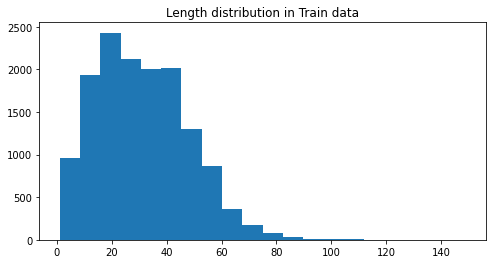

In [0]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Now we create data iterators and set the batch size

In [18]:

def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 64 # also can vary 64 /128 (64 лучше)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[224, 26, 27]

This is an example of the simplest RNN model that consists of an embedding layer (len(vocab), hidden layer dimension), an RNN layer (LSTM in this case) (hidden dimension) and finally a linear layer (hidden dimension or 2*hidden dimension if our net is biderectional, num of our classes (tags))that will classify our tags, in other. words "tag" them in this case.

In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False,  rnn="LSTM"):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        if rnn == "LSTM":
          self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional)
        else:
          self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=bidirectional)
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, int(output_dim))

    def forward(self, sent):
        
        embedded = self.dropout(self.embeddings(sent)) 

        output, _ = self.rnn(embedded) 
        

        prediction = self.tag(output) 
    
        return prediction
        


In [0]:
# these are our parameters
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM =300 # 
HID_DIM = 228 #228 # 128  256 
DROPOUT = 0.4 # 0.3 0.2 0.4 0.5 
BIDIRECTIONAL = True # False True

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM,  OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform(param, -0.08, 0.08)
        
        
model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  del sys.path[0]


LSTMTagger(
  (embeddings): Embedding(34682, 300)
  (dropout): Dropout(p=0.4, inplace=False)
  (rnn): LSTM(300, 228, bidirectional=True)
  (tag): Linear(in_features=456, out_features=18, bias=True)
)

We also create an optimizer and set a loss (Cross Entrophy in this case). Also, it is important to ignore the "pad" tag as it is easy for a model to identify it, so we may be misled by the high quality which is simply the result of a model predicting "pad". So, we get rid of this bias by ignoring the tag.

In [0]:
TAG_PAD_IDX = TAG.vocab.stoi['<pad>'] 
optimizer = optim.Adam(model.parameters(), lr = 0.001) # lr0.001 0.002 0.0005 
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


Now let's train the first model

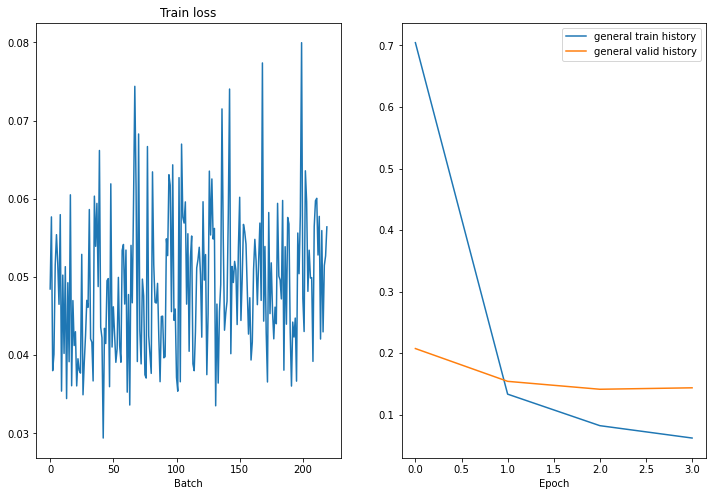

Epoch: 05 | Time: 0m 18s
	Train Loss: 0.049 | Train PPL:   1.050
	 Val. Loss: 0.149 |  Val. PPL:   1.161


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bi-LSTM.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

There are the results with different parameters. Firstly, we fit a general model, then try bidirectionality

In [0]:
#no bidirecrional, hid dim 128, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator,name='best-val-model-LSTM.pt')

Accuracy train: 97.566 %
Accuracy valid: 94.509 %
Accuracy test: 94.445 %
F1 score macro train: 79.64793916916871 %
F1 score macro valid: 80.68634508564428 %
F1 score macro test: 80.87914585073376 %
F1 score micro train: 97.56621444122568 %
F1 score micro valid: 94.50856007337207 %
F1 score micro test: 94.44476119885208 %


In [0]:
# no bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator, ,name='best-val-model-LSTM.pt')

Accuracy train: 98.017 %
Accuracy valid: 94.398 %
Accuracy test: 94.333 %
F1 score macro train: 0.8272690934616684 %
F1 score macro valid: 0.8315739456507008 %
F1 score macro test: 0.8406778143869387 %
F1 score micro train: 0.9801694046098206 %
F1 score micro valid: 0.9439773769489452 %
F1 score micro test: 0.9433263013854838 %


In [0]:
# no bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, ,name='best-val-model-LSTM.pt')

Accuracy train: 97.468 %
Accuracy valid: 94.417 %
Accuracy test: 94.325 %
F1 score macro train: 0.7929497126562621 %
F1 score macro valid: 0.7999067163718815 %
F1 score macro test: 0.8064402759518497 %
F1 score micro train: 0.974679273800313 %
F1 score micro valid: 0.9441684500152858 %
F1 score micro test: 0.9432502803276508 %


In [0]:
# no bidirecrional, hid dim 128, dropout 0.2 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator,,name='best-val-model-LSTM.pt')

Accuracy train: 97.774 %
Accuracy valid: 94.354 %
Accuracy test: 94.196 %
F1 score macro train: 0.8140760427440588 %
F1 score macro valid: 0.8048079167385405 %
F1 score macro test: 0.839710496344559 %
F1 score micro train: 0.9777425913597352 %
F1 score micro valid: 0.943537908896362 %
F1 score micro test: 0.9419579223444894 %


So, the best quality is 
* Accuracy train: 97.566 %
* Accuracy valid: 94.509 %
* Accuracy test: 94.445 %
* F1 score macro train: 79.64793916916871 %
* F1 score macro valid: 80.68634508564428 %
* F1 score macro test: 80.87914585073376 %
* F1 score micro train: 97.56621444122568 %
* F1 score micro valid: 94.50856007337207 %
* F1 score micro test: 94.44476119885208 %


Results with bi-directional LSTM

In [0]:
#  bidirecrional, hid dim 128, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator, , name='best-val-model-bi-LSTM.pt')

Accuracy train: 98.685 %
Accuracy valid: 95.617 %
Accuracy test: 95.389 %
F1 score macro train: 0.8871818817593556 %
F1 score macro valid: 0.8904148965401542 %
F1 score macro test: 0.8888503649246609 %
F1 score micro train: 0.9868493261601022 %
F1 score micro valid: 0.9561678385814736 %
F1 score micro test: 0.9538932284242735 %


In [0]:
#  bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi-LSTM.pt')

Accuracy train: 98.367 %
Accuracy valid: 95.733 %
Accuracy test: 95.598 %
F1 score macro train: 88.11910213410371 %
F1 score macro valid: 90.20264077378444 %
F1 score macro test: 88.6965330875044 %
F1 score micro train: 98.36780502725948 %
F1 score micro valid: 95.7333384286151 %
F1 score micro test: 95.59838075146816 %


In [0]:
#  bidirecrional, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, , name='best-val-model-bi-LSTM.pt')

Accuracy train: 97.945 %
Accuracy valid: 95.294 %
Accuracy test: 95.087 %
F1 score macro train: 0.8246548806125956 %
F1 score macro valid: 0.8280174485790588 %
F1 score macro test: 0.8363068577937514 %
F1 score micro train: 0.9794339384997391 %
F1 score micro valid: 0.952938703760318 %
F1 score micro test: 0.950871391375411 %


In [0]:
#  bidirecrional, hid dim 228, dropout 0.5 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, , name='best-val-model-bi-LSTM.pt')

Accuracy train: 98.637 %
Accuracy valid: 95.728 %
Accuracy test: 95.452 %
F1 score macro train: 0.8951574930264775 %
F1 score macro valid: 0.9074091474123871 %
F1 score macro test: 0.8997833649310918 %
F1 score micro train: 0.9863725102110585 %
F1 score micro valid: 0.9572760623662488 %
F1 score micro test: 0.9545204021513959 %


From the results, it can be seen that LSTM is quite effective for this task (more than 94 % accuracy). However, bidirectionality is certainly a huge benefit as it increases quality approximately by 1 percent.\
The best quality is:

* Accuracy train: 98.367 %
* Accuracy valid: 95.733 %
* Accuracy test: 95.598 %
* F1 score macro train: 88.11910213410371 %
* F1 score macro valid: 90.20264077378444 %
* F1 score macro test: 88.6965330875044 %
* F1 score micro train: 98.36780502725948 %
* F1 score micro valid: 95.7333384286151 %
* F1 score micro test: 95.59838075146816 %

In [0]:
report, cm = statistics(model, test_iterator, TAG, pred_func=get_preds)
print(report)

              precision    recall  f1-score   support

        NOUN       0.92      0.95      0.94      9524
         ADP       1.00      1.00      1.00      8332
         DET       0.99      0.99      0.99      7188
       PUNCT       1.00      1.00      1.00      6314
        VERB       0.94      0.95      0.94      4320
       PROPN       0.89      0.84      0.86      4115
         ADJ       0.89      0.88      0.89      3464
        PRON       0.95      0.95      0.95      2349
         ADV       0.97      0.95      0.96      1712
         AUX       0.95      0.94      0.94      1621
       CCONJ       0.99      1.00      0.99      1439
       SCONJ       0.93      0.95      0.94      1209
         NUM       0.97      0.88      0.92       962
         SYM       0.91      0.78      0.84        37
        PART       0.73      0.44      0.55        18
        INTJ       1.00      0.31      0.47        13

    accuracy                           0.96     52617
   macro avg       0.94   

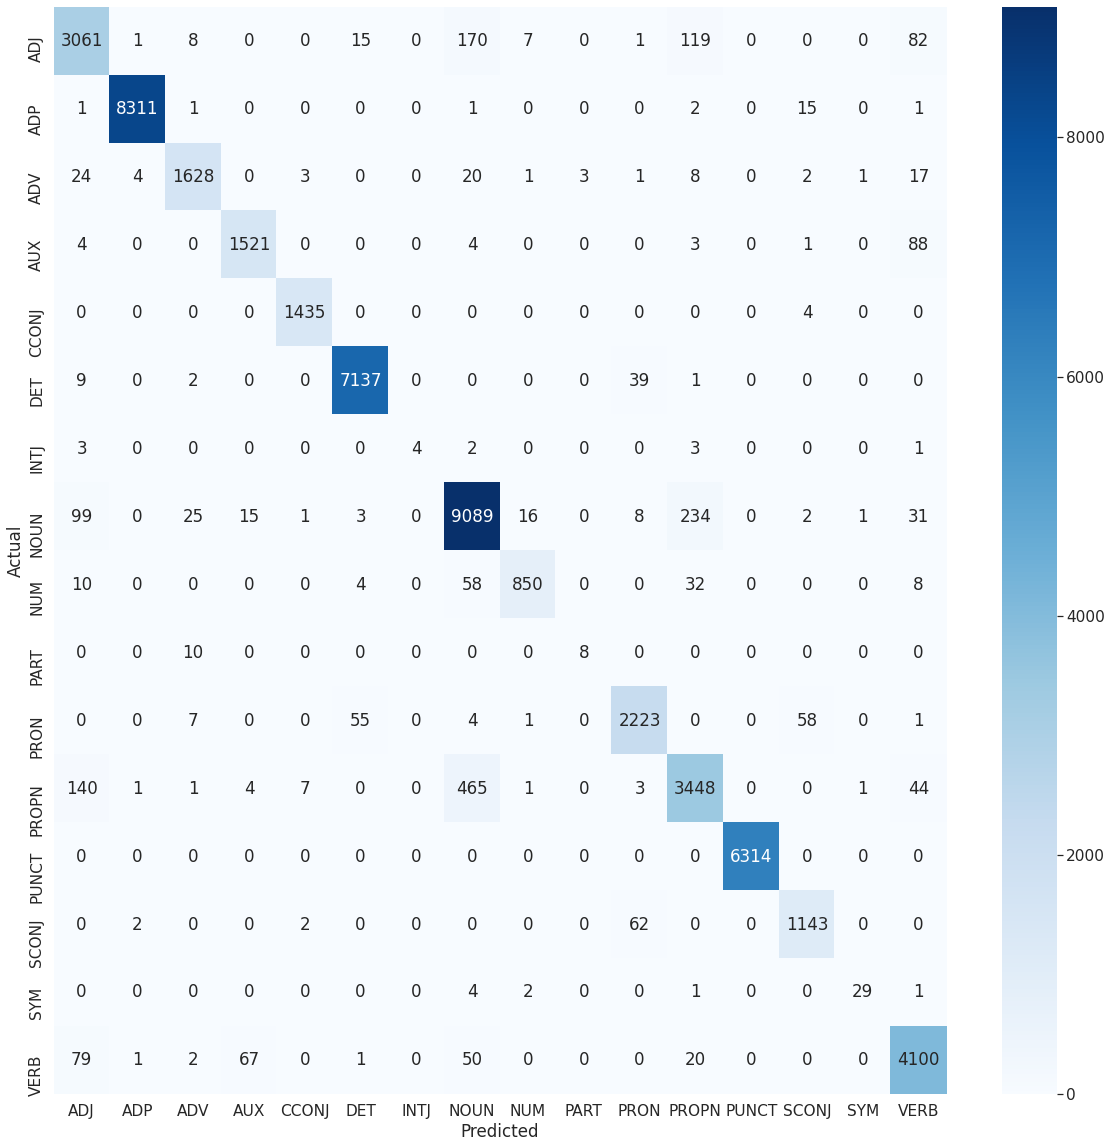

In [0]:
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)
sns.heatmap(cm.to_dataframe(), cmap="Blues", annot=True, fmt="d")

## biLSTM + Glove embeddings

---
It is possible to train good embeddings on your dataset, but it it takes quite a long time and it may notbe  as effective as pretrained on a big corpus embeddings. Now, we will try. Glove embeddings for Spanish
---

Firstly, we wil download them with genism



In [19]:
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = '/content/drive/My Drive/Cup_It/glove-sbwc.i25.vec.gz'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Now extract them and create an embedding layer

In [20]:
wordvectors.wv.save_word2vec_format('spanish')
vectors = vocab.Vectors('/content/spanish') 
WORD.vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)

embedding = nn.Embedding.from_pretrained(torch.FloatTensor(WORD.vocab.vectors))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|█████████▉| 99631/100000 [00:09<00:00, 10951.22it/s]


Again, we create batches and a model

In [0]:
def _len_sort_key(x):
    return len(x.words)
BATCH_SIZE = 64 #64 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

Actually, the previous model can be easily upgrated to this one but to be more representative we wil create a new class,adding also the feature o changing the number of layers

In [0]:
class BiLSTMGloveTagger(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx, rnn="LSTM"):
        
        super().__init__()

        self.rnn_type = rnn
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        if rnn == 'LSTM':
          self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        else:
          self.gru = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
          
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        embedded = self.dropout(self.embedding(text))
        if self.rnn_type == "LSTM":
          outputs, (hidden, cell) = self.lstm(embedded)
        else:
          outputs, _ = self.gru(embedded)

        predictions = self.fc(self.dropout(outputs))
        
        
        
        return predictions

Again, some hyperparameters to tune

In [0]:
INPUT_DIM = len(WORD.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 228 #228
OUTPUT_DIM = len(TAG.vocab)
N_LAYERS =2 #2
BIDIRECTIONAL = True
DROPOUT = 0.25 #0.4 0.25
PAD_IDX = WORD.vocab.stoi[WORD.pad_token]

model = BiLSTMGloveTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

BiLSTMGloveTagger(
  (embedding): Embedding(34682, 300, padding_idx=1)
  (lstm): LSTM(300, 228, bidirectional=True)
  (fc): Linear(in_features=456, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Now it is time to take a look at the pretrained embeddings and add them to the model

In [0]:
pretrained_embeddings = WORD.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([34682, 300])


In [0]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4659, -0.3070, -0.1216,  ..., -0.5199, -0.1816,  0.0534],
        ...,
        [-0.4078,  0.2569, -0.1952,  ...,  0.0599, -0.2608, -0.3250],
        [ 0.1107, -0.3002,  0.6310,  ...,  0.5790, -0.0543, -0.2207],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [0]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4659, -0.3070, -0.1216,  ..., -0.5199, -0.1816,  0.0534],
        ...,
        [-0.4078,  0.2569, -0.1952,  ...,  0.0599, -0.2608, -0.3250],
        [ 0.1107, -0.3002,  0.6310,  ...,  0.5790, -0.0543, -0.2207],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


So, we add the embeddings to the model's weights and also set "pad"

In [0]:
optimizer = optim.Adam(model.parameters())
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

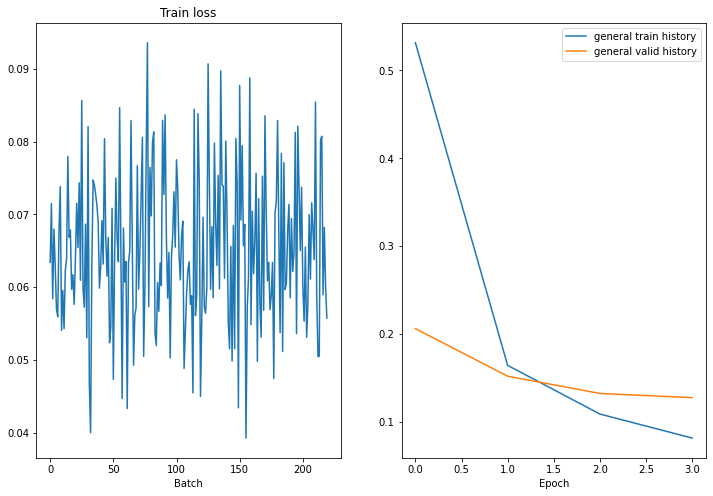

Epoch: 05 | Time: 0m 18s
	Train Loss: 0.065 | Train PPL:   1.068
	 Val. Loss: 0.125 |  Val. PPL:   1.133


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-glove.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

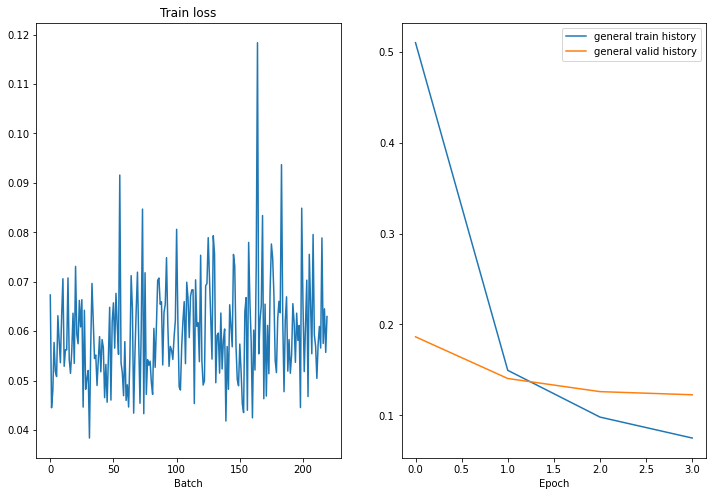

Epoch: 05 | Time: 0m 31s
	Train Loss: 0.060 | Train PPL:   1.062
	 Val. Loss: 0.126 |  Val. PPL:   1.134


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-glove.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

There are also results with different parameters

In [0]:
#  bidirecrional glove, hid dim 228, dropout 0.4 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.005 %
Accuracy valid: 96.19 %
Accuracy test: 96.043 %
F1 score macro train: 0.874584186574792 %
F1 score macro valid: 0.9023537298209385 %
F1 score macro test: 0.885221950002564 %
F1 score micro train: 0.9800524497543948 %
F1 score micro valid: 0.9619000305716906 %
F1 score micro test: 0.9604310393979132 %


In [0]:
#  bidirecrional glove, hid dim 228, dropout 0.25 lr 0.001 5 epochs batch 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.573 %
Accuracy valid: 96.322 %
Accuracy test: 96.226 %
F1 score macro train: 0.8949753689005799 %
F1 score macro valid: 0.916500882602856 %
F1 score macro test: 0.907801174346715 %
F1 score micro train: 0.985738255033557 %
F1 score micro valid: 0.9632184347294406 %
F1 score micro test: 0.9622555447859057 %


In [0]:
# bidirecrional glove, hid dim 228, dropout 0.25 lr 0.001 5 epochs batch 64 2 layers
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.681 %
Accuracy valid: 96.41 %
Accuracy test: 96.273 %
F1 score macro train: 90.49778590842085 %
F1 score macro valid: 90.33062552666102 %
F1 score macro test: 90.82308281849627 %
F1 score micro train: 98.68088417870702 %
F1 score micro valid: 96.40973708346071 %
F1 score micro test: 96.27306763973621 %


In [0]:
#  bidirecrional glove, hid dim 228, dropout 0.25 lr 0.001 5 epochs batch 128 3 layers
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-glove.pt')

Accuracy train: 98.583 %
Accuracy valid: 96.274 %
Accuracy test: 96.186 %
F1 score macro train: 0.897699180871563 %
F1 score macro valid: 0.8896186362802241 %
F1 score macro test: 0.894909032274525 %
F1 score micro train: 0.9858327185706317 %
F1 score micro valid: 0.9627407520635891 %
F1 score micro test: 0.9618564342322823 %


The best result is:
* Accuracy train: 98.681 %
* Accuracy valid: 96.41 %
* Accuracy test: 96.273 %
* F1 score macro train: 90.49778590842085 %
* F1 score macro valid: 90.33062552666102 %
* F1 score macro test: 90.82308281849627 %
* F1 score micro train: 98.68088417870702 %
* F1 score micro valid: 96.40973708346071 %
* F1 score micro test: 96.27306763973621 %




Adding the pretrained embeddings allowed us to increase the test accuracy to 96 %

## Char embeddings time
---
Though word reprsentation already enables a model to show quite a high quality, it stil can be quite helpful to make the most of morphological patterns as they can contain important information about a part os speech category of a word. To take into acount this additional information we will create new features: char embeddings extracted with a use of a little CNN.


In [0]:
data_train1 = data_train
data_val1 = data_val
data_test1 = data_test

for i in data_train1:
  i.insert(0, i[0])
  
for i in data_val1:
  i.insert(0, i[0])

for i in data_test1:
  i.insert(0, i[0])


Now we create new fields.Here you can see CHAR field that contains symbols

In [0]:
from torchtext.data import Field, NestedField, BucketIterator
import torchtext

WORDS = Field(lower=True)
TAGS = Field(unk_token=None) 
CHARS_NESTING = Field(tokenize=list, init_token="<bos>", eos_token="<eos>", lower=True, fix_length=20) #we use fixed length of a sequence
CHARS = NestedField(CHARS_NESTING)

examples_train = []
for chars, words, tags in data_train1:
    examples_train.append(torchtext.data.Example.fromlist([list(chars), list(words), list(tags)], fields=[('chars', CHARS), ('words', WORDS),  ('tags', TAGS)]))

examples_val = []
for chars, words, tags in data_val1:
    examples_val.append(torchtext.data.Example.fromlist([list(chars), list(words), list(tags)], fields=[('chars', CHARS) ,('words', WORDS),  ('tags', TAGS)]))

examples_test = []
for chars, words, tags in data_test1:
    examples_test.append(torchtext.data.Example.fromlist([list(chars), list(words), list(tags)], fields=[('chars', CHARS) , ('words', WORDS), ('tags', TAGS)]))

That's how our chars features look before encoding them with ids

In [24]:

fields = [('chars', CHARS), ('words', WORDS), ('tags', TAGS)]
train_data = torchtext.data.Dataset(examples_train, fields=fields)
valid_data = torchtext.data.Dataset(examples_val, fields=fields)
test_data = torchtext.data.Dataset(examples_test, fields=fields)


print(train_data.fields)
print(len(train_data))
print(vars(train_data[1]))

{'chars': <torchtext.data.field.NestedField object at 0x7f690c9040b8>, 'words': <torchtext.data.field.Field object at 0x7f690ca65fd0>, 'tags': <torchtext.data.field.Field object at 0x7f690ca65f98>}
14305
{'chars': [['s', 'o', 'b', 'r', 'e'], ['l', 'a'], ['o', 'f', 'e', 'r', 't', 'a'], ['d', 'e'], ['i', 'n', 't', 'e', 'r', 'c', 'o', 'n', 'e', 'x', 'i', 'ó', 'n'], ['c', 'o', 'n'], ['t', 'e', 'l', 'e', 'f', 'ó', 'n', 'i', 'c', 'a'], ['d', 'e'], ['o', 't', 'r', 'o', 's'], ['o', 'p', 'e', 'r', 'a', 'd', 'o', 'r', 'e', 's'], ['q', 'u', 'e'], ['a', 'c', 'a', 'b', 'a'], ['d', 'e'], ['a', 'p', 'r', 'o', 'b', 'a', 'r'], ['l', 'a'], ['c', 'm', 't'], [','], ['v', 'á', 'z', 'q', 'u', 'e', 'z'], ['q', 'u', 'i', 'n', 't', 'a', 'n', 'a'], ['d', 'i', 'j', 'o'], ['q', 'u', 'e'], ['p', 'a', 'r', 'a'], ['d', 'e', 's', 'a', 'r', 'r', 'o', 'l', 'l', 'a', 'r'], ['l', 'a'], ['h', 'a', 'n'], ['e', 's', 'c', 'u', 'c', 'h', 'a', 'd', 'o'], ['a'], ['l', 'o', 's'], ['o', 'p', 'e', 'r', 'a', 'd', 'o', 'r', 'e', 's'

In [25]:
WORDS.build_vocab(train_data.words) 
CHARS.build_vocab(train_data.chars) 
TAGS.build_vocab(train_data.tags)


BATCH_SIZE = 128 # 128 # 64
def _len_sort_key(x):
    return len(x.words)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

batch = next(iter(train_iterator))

print("words", batch.words)
print("chars", batch.chars)
print("tags", batch.tags)

words tensor([[ 153,    4,    5,  ..., 2402,    5,   52],
        [ 835,  263,  364,  ...,   27, 1124, 4246],
        [   3,  437,   25,  ...,   65, 8929,   69],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')
chars tensor([[[ 2,  6, 14,  ...,  1,  1,  1],
         [ 2,  4,  8,  ...,  1,  1,  1],
         [ 2, 18,  3,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 2, 11,  5,  ...,  1,  1,  1],
         [ 2, 13,  6,  ...,  1,  1,  1],
         [ 2,  4,  7,  ...,  1,  1,  1],
         ...,
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1],
         [ 1,  1,  1,  ...,  1,  1,  1]],

        [[ 2,  4, 11,  ...,  1,  1,  1],
         [ 2,  6, 19,  ...,  1,  1,  1],
         [ 2,  4,  7,  ...,  1,  1,  1]

Again, we will set pretrained embeddings

In [0]:
WORDS.vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(WORDS.vocab.vectors))


This is our model. It consists of a little CNN net that is used to extract some patterns from the char embedding, which we then concat with our word embeddings and fit to the rnn layer. Finally, there is a classy classifier on top.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class WordCharCNNEmbeddingLSTM(nn.Module):

    def __init__(self,
                 hid_dim,
                 output_dim,
                 word_num_embedding,
                 char_num_embedding,
                 padding_size=2,
                 
                 word_embedding_dim=300,
                 word_padding_idx=1,
                
                 char_embedding_dim=228, #228
                 char_padding_idx=1,
                 dropout=0.4,
                 kernel_size=3,
                 out_channels=300, #228,
                 pretrained_word_embedding=None,
                 bidirectional=True):
      
        super().__init__()
        self.char_embedding = nn.Embedding(
            char_num_embedding, char_embedding_dim, char_padding_idx)
        self._init_char_embedding(char_padding_idx)
        self.conv_embedding = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(kernel_size, char_embedding_dim)))
        self.word_embedding = nn.Embedding(
            word_num_embedding, word_embedding_dim, word_padding_idx)
        if isinstance(pretrained_word_embedding, torch.Tensor):
            self.word_embedding.weight.data.copy_(pretrained_word_embedding)
            
            self.word_embedding.weight.requires_grad = False
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(word_embedding_dim+out_channels, hid_dim, bidirectional=bidirectional)
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, int(output_dim))
 

    def _init_char_embedding(self, padding_idx):

        nn.init.xavier_normal_(self.char_embedding.weight)
        
        self.char_embedding.weight.data[padding_idx].uniform_(0, 0)

    def forward(self, X, X_word):
        word_size = X.size(1)
        char_embeddings = []
        
        for i in range(word_size):
            
            x = X[:, i, :].unsqueeze(1)
            
            char_embedding = self.char_embedding(x)
            
            char_embedding = self.conv_embedding(char_embedding)
           
            char_embedding = char_embedding.squeeze(-1)
            
            char_embedding = F.max_pool2d(
                char_embedding,
                kernel_size=(1, char_embedding.size(2)),
                stride=1)
            
            char_embeddings.append(char_embedding.transpose(1, 2))

        
        final_char_embedding = torch.cat(char_embeddings, dim=1)
        word_embedding =  self.dropout(self.word_embedding(X_word))
        
        result = torch.cat([final_char_embedding.permute(1,0,2), word_embedding], 2)
        
        output, _ = self.rnn(result)

        prediction = self.tag(output) 
        return prediction


In [0]:
OUTPUT_DIM = len(TAGS.vocab)
 # стандарт не варьируем
HID_DIM = 228
model = WordCharCNNEmbeddingLSTM(HID_DIM, len(TAGS.vocab), len(WORDS.vocab), len(CHARS.vocab), pretrained_word_embedding=embeddings).to(device)


In [0]:
TAG_PAD_IDX = TAGS.vocab.stoi['<pad>'] 
optimizer = optim.Adam(model.parameters(), lr = 0.001) # lr0.001 0.002 0.0005
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform(param, -0.08, 0.08)
        
model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


WordCharCNNEmbeddingLSTM(
  (char_embedding): Embedding(81, 228, padding_idx=1)
  (conv_embedding): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Conv2d(1, 300, kernel_size=(3, 228), stride=(1, 1))
  )
  (word_embedding): Embedding(34682, 300, padding_idx=1)
  (dropout): Dropout(p=0.4, inplace=False)
  (rnn): LSTM(600, 228, bidirectional=True)
  (tag): Linear(in_features=456, out_features=18, bias=True)
)

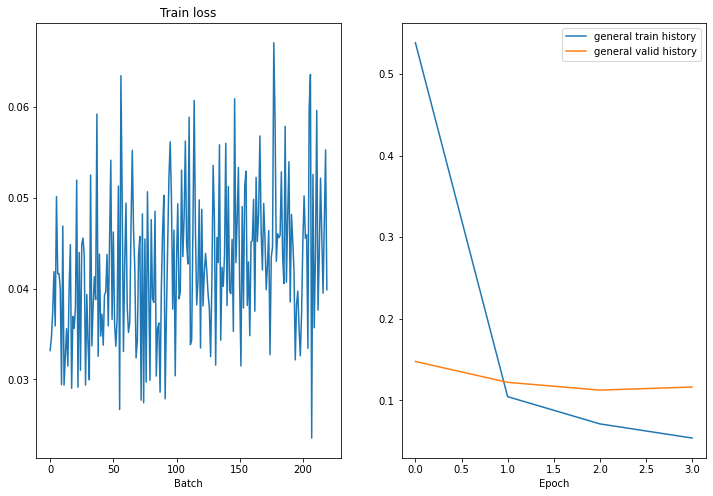

Epoch: 05 | Time: 3m 19s
	Train Loss: 0.043 | Train PPL:   1.044
	 Val. Loss: 0.125 |  Val. PPL:   1.133


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1 #поменять??

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, is_char=True)
    valid_loss = evaluate(model, valid_iterator, criterion, is_char=True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-char.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

There are some results with different parameters

In [0]:
# char without pretrained embeddings 228. output 0.4 dropout batch 128 all the lower ones are 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.854 %
Accuracy valid: 96.41 %
Accuracy test: 96.235 %
F1 score macro train: 90.19128581858526 %
F1 score macro valid: 92.85980644249508 %
F1 score macro test: 92.12687815834823 %
F1 score micro train: 98.85451715637764 %
F1 score micro valid: 96.40973708346071 %
F1 score micro test: 96.2350571108197 %


In [0]:
# char without pretrained embeddings 228. output 0.25 dropout
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.652 %
Accuracy valid: 96.475 %
Accuracy test: 96.264 %
F1 score macro train: 89.83641332161604 %
F1 score macro valid: 92.30304418111312 %
F1 score macro test: 90.93642574508256 %
F1 score micro train: 98.65142055166706 %
F1 score micro valid: 96.47470192601651 %
F1 score micro test: 96.26356500750708 %


In [0]:
# char without pretrained embeddings 228. output
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.715 %
Accuracy valid: 95.751 %
Accuracy test: 95.68 %
F1 score macro train: 90.20859535622259 %
F1 score macro valid: 92.30365595066256 %
F1 score macro test: 92.35933964733228 %
F1 score micro train: 98.71439624305019 %
F1 score micro valid: 95.75053500458576 %
F1 score micro test: 95.68010338863864 %


In [0]:
# char with pretrained embeddings 300 output 64 batch 
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.507 %
Accuracy valid: 96.511 %
Accuracy test: 96.404 %
F1 score macro train: 89.24152325077685 %
F1 score macro valid: 93.19529631436295 %
F1 score macro test: 91.58845173508622 %
F1 score micro train: 98.50680137466938 %
F1 score micro valid: 96.51100580862122 %
F1 score micro test: 96.40420396449817 %


In [0]:
#gloves drop 0.25 char 228. batch_size 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.426 %
Accuracy valid: 96.272 %
Accuracy test: 96.205 %
F1 score macro train: 88.3545771622451 %
F1 score macro valid: 92.122273586368 %
F1 score macro test: 90.05457462578744 %
F1 score micro train: 98.42560771542185 %
F1 score micro valid: 96.2721644756955 %
F1 score micro test: 96.20464868768649 %


In [0]:
#gloves drop 0.5 char 228 batch 64
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.722 %
Accuracy valid: 96.253 %
Accuracy test: 96.169 %
F1 score macro train: 89.9476227775819 %
F1 score macro valid: 92.22429188357356 %
F1 score macro test: 91.7102380615702 %
F1 score micro train: 98.72181837810605 %
F1 score micro valid: 96.25305716906145 %
F1 score micro test: 96.16853868521581 %


In [0]:
#gloves drop 0.5 char 128
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-char.pt', is_char=True)

Accuracy train: 98.725 %
Accuracy valid: 96.156 %
Accuracy test: 95.99 %
F1 score macro train: 89.97170481442815 %
F1 score macro valid: 91.93230048531686 %
F1 score macro test: 91.17310362068794 %
F1 score micro train: 98.72519207585871 %
F1 score micro valid: 96.15560990522776 %
F1 score micro test: 95.98988919930821 %


As we see, this did not give us a significant increase in quality: we have a new champion:
* Accuracy train: 98.507 %
* Accuracy valid: 96.511 %
* Accuracy test: 96.404 %
* F1 score macro train: 89.24152325077685 %
* F1 score macro valid: 93.19529631436295 %
* F1 score macro test: 91.58845173508622 %
* F1 score micro train: 98.50680137466938 %
* F1 score micro valid: 96.51100580862122 %
* F1 score micro test: 96.40420396449817 %

In [0]:
def get_preds(model, iterator, is_char):
  model.eval()
  preds = []
  tags_given = []
  with torch.no_grad():
        for i, batch in enumerate(iterator):
            if is_char:
              words = batch.words
              chars = batch.chars 
              tags = batch.tags
              output = model(chars, words)
            else:
              words = batch.words 
              tags = batch.tags

              output = model(words) 
            
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices ###
            tags = tags.view(-1)

            predict_tags = output.squeeze().cpu().numpy()
            
            true_tags = tags.cpu().numpy()
            args = np.where(true_tags!=TAG_PAD_IDX)[0]

            predict_tags = predict_tags[args]
            true_tags = true_tags[args]

            if i==0:
              preds = predict_tags
              tags_given = true_tags
            else:
              preds = np.append(preds, predict_tags)
              
              tags_given = np.append(tags_given, true_tags)
        
  return preds, tags_given

In [0]:
TAG_PAD_IDX = 0

In [65]:
result, cm = statistics(model, test_iterator, TAG,name='best-val-model-char.pt', is_char=True)
print(result)

              precision    recall  f1-score   support

        NOUN       0.94      0.96      0.95      9524
         ADP       1.00      1.00      1.00      8332
         DET       0.99      1.00      0.99      7188
       PUNCT       1.00      1.00      1.00      6314
        VERB       0.96      0.96      0.96      4320
       PROPN       0.92      0.85      0.88      4115
         ADJ       0.90      0.93      0.91      3464
        PRON       0.97      0.94      0.95      2349
         ADV       0.97      0.97      0.97      1712
         AUX       0.96      0.93      0.95      1621
       CCONJ       0.99      1.00      0.99      1439
       SCONJ       0.94      0.96      0.95      1209
         NUM       0.95      0.97      0.96       962
         SYM       0.97      0.95      0.96        37
        PART       0.76      0.72      0.74        18
        INTJ       1.00      0.31      0.47        13

    accuracy                           0.96     52617
   macro avg       0.95   

In [67]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


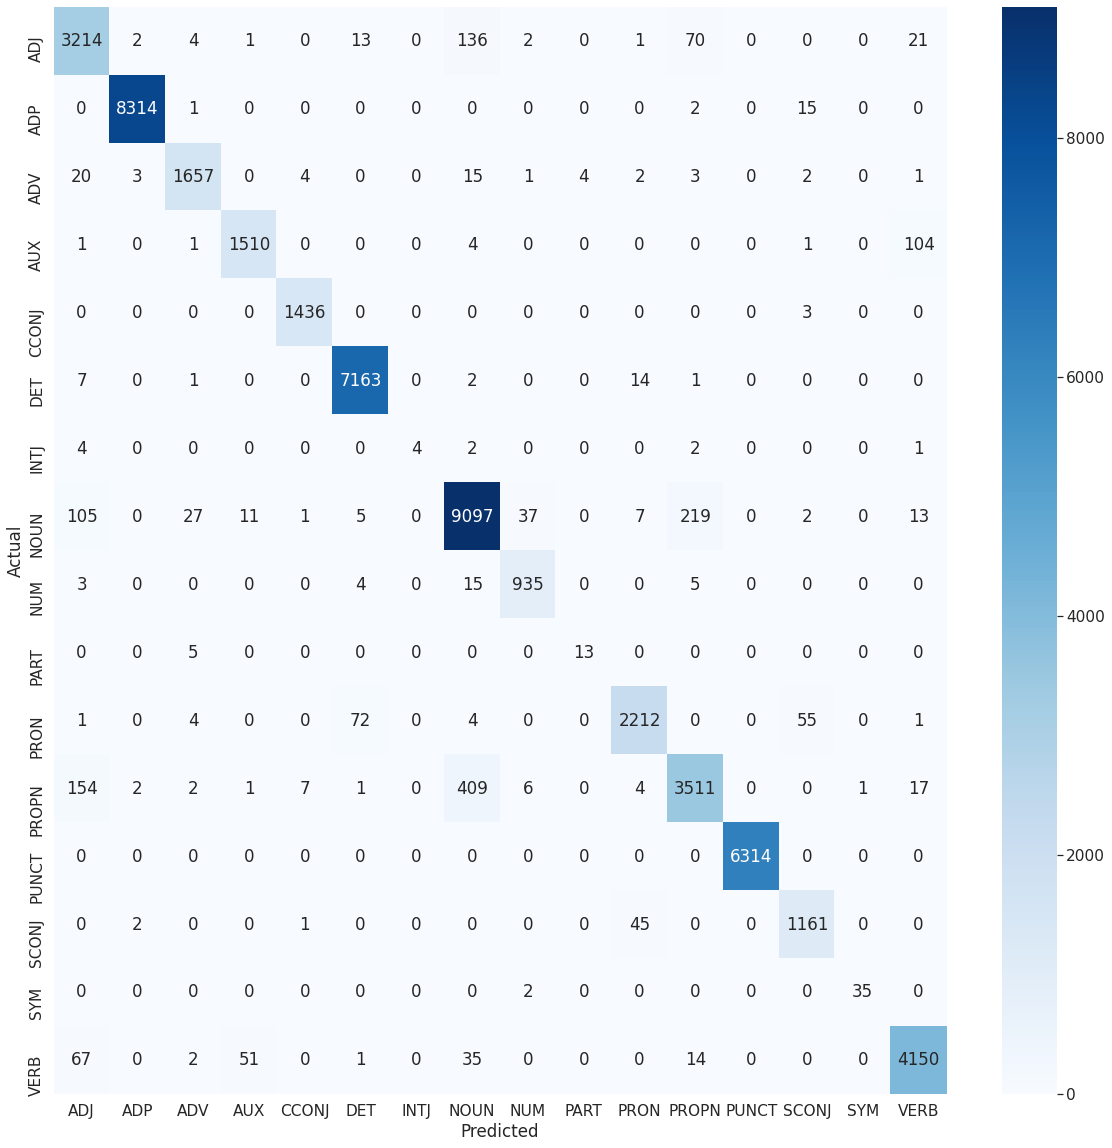

In [68]:
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)
sns.heatmap(cm.to_dataframe(), cmap="Blues", annot=True, fmt="d")

In [0]:
y_pred,y_true, words = get_preds(model, test_iterator, is_char=True, text=True)

In [0]:
inxtoword = {i:j for j, i in WORDS.vocab.stoi.items()}

In [0]:
def find_errors(pred, true, words):
    error_counter = Counter()
    support = 0
    for w, true, pred in zip(words, true, pred):
                if true != pred:
                    word = inxtoword[w]
                    error_counter[word] += 1
                support += 1
    return error_counter, support

errors, support = find_errors(y_pred, y_true, words)


In [74]:
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:')
for i in errors.most_common(20):
  print(i)

Total errors/Total words: 1891/52617 | Accuracy: 0.9641

Most common errors:
('barinas', 467)
('que', 86)
('cuando', 17)
('como', 16)
('unos', 13)
('la', 12)
('estado', 11)
('todo', 10)
('gobierno', 10)
('no', 9)
('una', 9)
('está', 8)
('lo', 7)
('un', 7)
('medio', 7)
('vuelta', 7)
('pacto', 7)
('ayuntamiento', 7)
('u', 7)
('tanto', 6)


## CRF

---
This is another significant addition to a neural network. Conditiional Random Field as the last layer allows us to find a most probable sequence of tags 
, given word x, weights w and bias b

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/07/image1.png)

Here we also have to define one more time some helper functions as they wil be slightly different for a model with CRF

In [0]:
def acc(model, iterator, TAG_PAD_IDX=1, is_char=False):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            if is_char:
              words = batch.words
              chars = batch.chars
              tags = batch.tags
              output = model.predict(chars, words)
            else:
              words = batch.words
              tags = batch.tags

              output = model.predict(words) 
            
            
            tags = tags.view(-1)
            output =output.reshape(-1)
           
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()
            
            true_pred += np.sum((true_tags == predict_tags) & (true_tags != TAG_PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == TAG_PAD_IDX).sum()
            
    return round(true_pred / num_pred * 100, 3)


def get_pr(model, iterator, is_char, text=False):
  model.eval()
  preds = []
  tags_given = []
  if text:
    words_l = []
  with torch.no_grad():
        for i, batch in enumerate(iterator):
            if is_char:
              words = batch.words
              chars = batch.chars 
              tags = batch.tags
              output = model.predict(chars, words)
              if text:
                words1 = words.view(-1).cpu().numpy()
            else:
              words = batch.words 
              tags = batch.tags

              output = model.predict(words) 
              if text:
                words1 = words.view(-1).cpu().numpy()
            
            output = output.reshape(-1) 
            tags = tags.view(-1)

            predict_tags = output.squeeze().cpu().numpy()
            
            true_tags = tags.cpu().numpy()
            args = np.where(true_tags!=TAG_PAD_IDX)[0]
            if text:
              words1 = words1[args]
            predict_tags = predict_tags[args]
            true_tags = true_tags[args]

            if i==0:
              preds = predict_tags
              tags_given = true_tags
              if text:
                words_l = words1
            else:
              preds = np.append(preds, predict_tags)
              
              tags_given = np.append(tags_given, true_tags)
              if text:
                words_l = np.append(words_l, words1)
  if text:
      return preds, tags_given, words_l
  else:      
    return preds, tags_given


def get_f1(model, iterator, is_char=False):
  from sklearn.metrics import f1_score
  preds, tags = get_pr(model, iterator, is_char)
  f1_score_macro = f1_score(tags, preds, average='macro') * 100
  f1_score_micro = f1_score(tags, preds, average='micro') * 100
  return f1_score_macro, f1_score_micro



def print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bi.pt', is_char=False):
  model.load_state_dict(torch.load(name))
  print("Accuracy train:", acc(model, train_iterator,is_char=is_char), '%')
  print("Accuracy valid:", acc(model, valid_iterator, is_char=is_char), '%')
  print("Accuracy test:", acc(model, test_iterator, is_char=is_char), '%')
  macro_train, micro_train = get_f1(model, train_iterator, is_char=is_char)
  macro_valid, micro_valid = get_f1(model, valid_iterator, is_char=is_char)
  macro_test, micro_test = get_f1(model, test_iterator, is_char=is_char)
  print("F1 score macro train:", macro_train, "%")
  print("F1 score macro valid:", macro_valid, "%")
  print("F1 score macro test:", macro_test, "%")
  print("F1 score micro train:", micro_train, "%")
  print("F1 score micro valid:", micro_valid, "%")
  print("F1 score micro test:", micro_test, "%")

In [0]:
def statistics(model, iterator, tag_field, pred_func=get_pr, name=None, is_char=True):
  if name:
    model.load_state_dict(torch.load(name))
  y_pred, y_true = pred_func(model, iterator, is_char=is_char)
  report = classification_report(y_true, y_pred, target_names=tag_field.vocab.itos[1:-1])
  ixtotag = {i:j for j, i in tag_field.vocab.stoi.items()}
  cm = ConfusionMatrix([ixtotag[i] for i in y_true], [ixtotag[i] for i in y_pred], labels=tag_field.vocab.itos)
  return report, cm


Now it is a CRF model. The Viterbi algorithm is used to decode the most probable sequence

In [0]:
class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, dropout= 0.4, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)
        self.drop = nn.Dropout(dropout)
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)

        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences):
        embedded = self.drop(self.embedding(sentences))
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, sentences, labels):
        
        scores = self.compute_outputs(sentences)

        return -self.crf(scores, labels)
            
    def predict(self, sentences):
       
        scores = self.compute_outputs(sentences)

        return torch.Tensor(np.array(self.crf.decode(scores)).T)

In [0]:
#calculations of numbers of tokens and batches to find a mean
n_tokens_train = 0
n_sentences_train = 0
for ex in examples_train:
      n_tokens_train += len(ex.words) + 2
      n_sentences_train += 1
n_tokens_valid = 0       
for ex in examples_val:
      n_tokens_valid += len(ex.words)

n_tokens_val = 0
n_sentences_val = 0
for ex in examples_val:
      n_tokens_val += len(ex.words) + 2
      n_sentences_val += 1
n_tokens_val = 0       
for ex in examples_val:
      n_tokens_val += len(ex.words)


n_batches = np.ceil(n_sentences_train / BATCH_SIZE)
n_batches_val = np.ceil(n_sentences_val/BATCH_SIZE)
mean_n_tokens = n_tokens_train / n_batches
mean_v_tokens = n_tokens_val / n_batches

In [0]:
from torchcrf import CRF

In [0]:
model = RNNCRFTagger(WORDS, TAGS, 300, 228, update_pretrained=False)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5) #0.01, 0.001

In [0]:
n_labels = len(TAGS.vocab)
history = defaultdict(list)   

best_valid_loss = float('inf')  

n_epochs = 5
        
for i in range(n_epochs):

    

    loss_sum = 0

    
    for j, batch in enumerate(train_iterator): 
            model.train()
                
            loss = model(batch.words, batch.tags) / mean_n_tokens
                
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

    train_loss = loss_sum / n_batches
    history['train_loss'].append(train_loss)


    loss_val = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_iterator:  
            loss = model(batch.words, batch.tags) / mean_v_tokens
            loss_val += loss.item()
    
    val_loss = loss_val / n_batches
    history['val_loss'].append(val_loss)
    train_loss, valid_loss = history['train_loss'][i], history['val_loss'][i]

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-crf.pt')

    print(f'Epoch: {i+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 0.414 | Train PPL:   1.514
	 Val. Loss: 0.224 |  Val. PPL:   1.251
Epoch: 02
	Train Loss: 0.166 | Train PPL:   1.181
	 Val. Loss: 0.157 |  Val. PPL:   1.170
Epoch: 03
	Train Loss: 0.107 | Train PPL:   1.113
	 Val. Loss: 0.138 |  Val. PPL:   1.148
Epoch: 04
	Train Loss: 0.083 | Train PPL:   1.086
	 Val. Loss: 0.138 |  Val. PPL:   1.147
Epoch: 05
	Train Loss: 0.073 | Train PPL:   1.075
	 Val. Loss: 0.134 |  Val. PPL:   1.143


In [0]:
# 128 batch, gloves, dropout 0.4, 
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-crf.pt', is_char=False)

Accuracy train: 99.541 %
Accuracy valid: 96.203 %
Accuracy test: 96.081 %
F1 score macro train: 95.2110026389365 %
F1 score macro valid: 88.85593943427806 %
F1 score macro test: 92.05361828777556 %
F1 score micro train: 98.54211274448062 %
F1 score micro valid: 95.47538978905533 %
F1 score micro test: 95.55466864321417 %


In [0]:
# 128 batch, gloves, dropout 0.4, 
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-crf.pt', is_char=False)

Accuracy train: 99.541 %
Accuracy valid: 96.205 %
Accuracy test: 96.111 %
F1 score macro train: 96.60980292624207 %
F1 score macro valid: 88.88962600762429 %
F1 score macro test: 90.75629095633077 %
F1 score micro train: 98.47576335534484 %
F1 score micro valid: 95.38940690920208 %
F1 score micro test: 95.56797232833495 %


Okay, the quality of the model is not really impressive
* Accuracy train: 99.541 %
* Accuracy valid: 96.205 %
* Accuracy test: 96.111 %
* F1 score macro train: 96.60980292624207 %
* F1 score macro valid: 88.88962600762429 %
* F1 score macro test: 90.75629095633077 %
* F1 score micro train: 98.47576335534484 %
* F1 score micro valid: 95.38940690920208 %
* F1 score micro test: 95.56797232833495 %

## biLSTM + CNN + CRF
---
This combination is usually considered one of the most powerful in sequence labelling, so, lets try to bring these three coponents together t see whether they are really strong

![alt text](https://i.ytimg.com/vi/zhqJPYHxJNY/maxresdefault.jpg)

In [178]:
tokenizer.tokenize("")

['Yo', 'quiero', 'vivir', 'en', 'Moscú']

In [0]:
class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, char_num_embedding,
                 padding_size=2 ,char_embedding_dim=228,
                 char_padding_idx=1,
                 dropout=0.25,
                 kernel_size=3,
                 out_channels=228, update_pretrained=False, rnn="LSTM"):
      
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)  


        self.char_embedding = nn.Embedding(
            char_num_embedding, char_embedding_dim, char_padding_idx)
        self._init_char_embedding(char_padding_idx)
        self.conv_embedding = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Conv2d(
                in_channels=1,
                out_channels=out_channels,
                kernel_size=(kernel_size, char_embedding_dim)))     
        
        self.word_embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.word_embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.dropout = nn.Dropout(p=dropout)

        if rnn=='LSTM':
          self.rnn = nn.LSTM(input_size=emb_dim+out_channels, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)
        else:
          self.rnn = nn.GRU(input_size=emb_dim+out_channels, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
    
    def _init_char_embedding(self, padding_idx):

        nn.init.xavier_normal_(self.char_embedding.weight)
        self.char_embedding.weight.data[padding_idx].uniform_(0, 0)
        
    def compute_outputs(self, chars, sentences):
        word_size = chars.size(1)
        char_embeddings = []
  
        for i in range(word_size):
            x = chars[:, i, :].unsqueeze(1)
            char_embedding = self.char_embedding(x)
            char_embedding = self.conv_embedding(char_embedding)
            
            char_embedding = char_embedding.squeeze(-1)
            
            char_embedding = F.max_pool2d(
                char_embedding,
                kernel_size=(1, char_embedding.size(2)),
                stride=1)
           
            char_embeddings.append(char_embedding.transpose(1, 2))

        final_char_embedding = torch.cat(char_embeddings, dim=1)
        word_embedding =  self.word_embedding(sentences)
        result = torch.cat([final_char_embedding.permute(1,0,2), word_embedding], 2)
        
        rnn_out, _ = self.rnn(result)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, chars, sentences, labels):

        
        scores = self.compute_outputs(chars, sentences)

        return -self.crf(scores, labels)
            
    def predict(self, chars, sentences):

        scores = self.compute_outputs(chars, sentences)

        return torch.Tensor(np.array(self.crf.decode(scores)).T)

In [101]:
model = RNNCRFTagger(WORDS, TAGS, 300, 228, len(CHARS.vocab), update_pretrained=False)
model.to(device)

RNNCRFTagger(
  (char_embedding): Embedding(81, 228, padding_idx=1)
  (conv_embedding): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Conv2d(1, 228, kernel_size=(3, 228), stride=(1, 1))
  )
  (word_embedding): Embedding(34682, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (rnn): LSTM(528, 228, bidirectional=True)
  (top_layer): Linear(in_features=456, out_features=18, bias=True)
  (crf): CRF(num_tags=18)
)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [0]:
n_labels = len(TAGS.vocab)
history = defaultdict(list)   

best_valid_loss = float('inf')  

n_epochs = 5
        
for i in range(n_epochs):

    loss_sum = 0
    
    for j, batch in enumerate(train_iterator): 
            model.train()
               
            loss = model(batch.chars, batch.words, batch.tags) / mean_n_tokens
                
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

    train_loss = loss_sum / n_batches
    history['train_loss'].append(train_loss)



    loss_val = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_iterator:
                        
            loss = model(batch.chars, batch.words, batch.tags) / mean_v_tokens
            loss_val += loss.item()
    
    val_loss = loss_val / n_batches
    history['val_loss'].append(val_loss)
    train_loss, valid_loss = history['train_loss'][i], history['val_loss'][i]

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-crf-cnn-l.pt')
        
    print(f'Epoch: {i+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 0.316 | Train PPL:   1.372
	 Val. Loss: 0.130 |  Val. PPL:   1.139
Epoch: 02
	Train Loss: 0.101 | Train PPL:   1.106
	 Val. Loss: 0.109 |  Val. PPL:   1.115
Epoch: 03
	Train Loss: 0.081 | Train PPL:   1.084
	 Val. Loss: 0.104 |  Val. PPL:   1.110
Epoch: 04
	Train Loss: 0.071 | Train PPL:   1.074
	 Val. Loss: 0.100 |  Val. PPL:   1.105
Epoch: 05
	Train Loss: 0.065 | Train PPL:   1.067
	 Val. Loss: 0.100 |  Val. PPL:   1.105


In [103]:
n_labels = len(TAGS.vocab)
history = defaultdict(list)   

best_valid_loss = float('inf')  

n_epochs = 5
        
for i in range(n_epochs):

    loss_sum = 0
    
    for j, batch in enumerate(train_iterator): 
            model.train()
               
            loss = model(batch.chars, batch.words, batch.tags) / mean_n_tokens
                
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

    train_loss = loss_sum / n_batches
    history['train_loss'].append(train_loss)



    loss_val = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_iterator:
                        
            loss = model(batch.chars, batch.words, batch.tags) / mean_v_tokens
            loss_val += loss.item()
    
    val_loss = loss_val / n_batches
    history['val_loss'].append(val_loss)
    train_loss, valid_loss = history['train_loss'][i], history['val_loss'][i]

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-crf-cnn-l.pt')
        
    print(f'Epoch: {i+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01
	Train Loss: 0.299 | Train PPL:   1.348
	 Val. Loss: 0.117 |  Val. PPL:   1.124
Epoch: 02
	Train Loss: 0.087 | Train PPL:   1.091
	 Val. Loss: 0.101 |  Val. PPL:   1.106
Epoch: 03
	Train Loss: 0.070 | Train PPL:   1.073
	 Val. Loss: 0.097 |  Val. PPL:   1.102
Epoch: 04
	Train Loss: 0.062 | Train PPL:   1.064
	 Val. Loss: 0.095 |  Val. PPL:   1.099
Epoch: 05
	Train Loss: 0.057 | Train PPL:   1.058
	 Val. Loss: 0.098 |  Val. PPL:   1.103


In [0]:
# GRU
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-crf-cnn-g.pt', is_char=True)

Accuracy train: 99.55 %
Accuracy valid: 97.664 %
Accuracy test: 97.556 %
F1 score macro train: 90.8795788452305 %
F1 score macro valid: 90.87943010717522 %
F1 score macro test: 92.75722410924597 %
F1 score micro train: 98.26636918149593 %
F1 score micro valid: 96.68488229899114 %
F1 score micro test: 96.66647661402207 %


In [0]:
# LSTM
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-crf-cnn-l.pt', is_char=True)

Accuracy train: 99.516 %
Accuracy valid: 97.633 %
Accuracy test: 97.536 %
F1 score macro train: 90.09469501100892 %
F1 score macro valid: 91.78327095808412 %
F1 score macro test: 92.73292305539825 %
F1 score micro train: 98.21711319430699 %
F1 score micro valid: 96.63711403240599 %
F1 score micro test: 96.65507345534714 %


**Wow**, there is finally an improvement that we deserve! For now, it is the best model we have:
* Accuracy train: 99.55 %
* Accuracy valid: 97.664 %
* Accuracy test: 97.556 %
* F1 score macro train: 90.8795788452305 %
* F1 score macro valid: 90.87943010717522 %
* F1 score macro test: 92.75722410924597 %
* F1 score micro train: 98.26636918149593 %
* F1 score micro valid: 96.68488229899114 %
* F1 score micro test: 96.66647661402207 %

In [97]:
result, cm = statistics(model, test_iterator, TAGS, name='best-val-model-crf-cnn-g.pt')
print(result)

              precision    recall  f1-score   support

        NOUN       0.95      0.94      0.95      9524
         ADP       1.00      1.00      1.00      8332
         DET       0.99      1.00      0.99      7188
       PUNCT       1.00      1.00      1.00      6314
        VERB       0.96      0.97      0.96      4320
       PROPN       0.90      0.90      0.90      4115
         ADJ       0.92      0.91      0.92      3464
        PRON       0.97      0.96      0.97      2349
         ADV       0.97      0.97      0.97      1712
         AUX       0.98      0.92      0.95      1621
       CCONJ       0.99      1.00      0.99      1439
       SCONJ       0.94      0.97      0.96      1209
         NUM       0.95      0.97      0.96       962
         SYM       1.00      0.95      0.97        37
        PART       0.89      0.44      0.59        18
        INTJ       1.00      0.62      0.76        13

    accuracy                           0.97     52617
   macro avg       0.96   

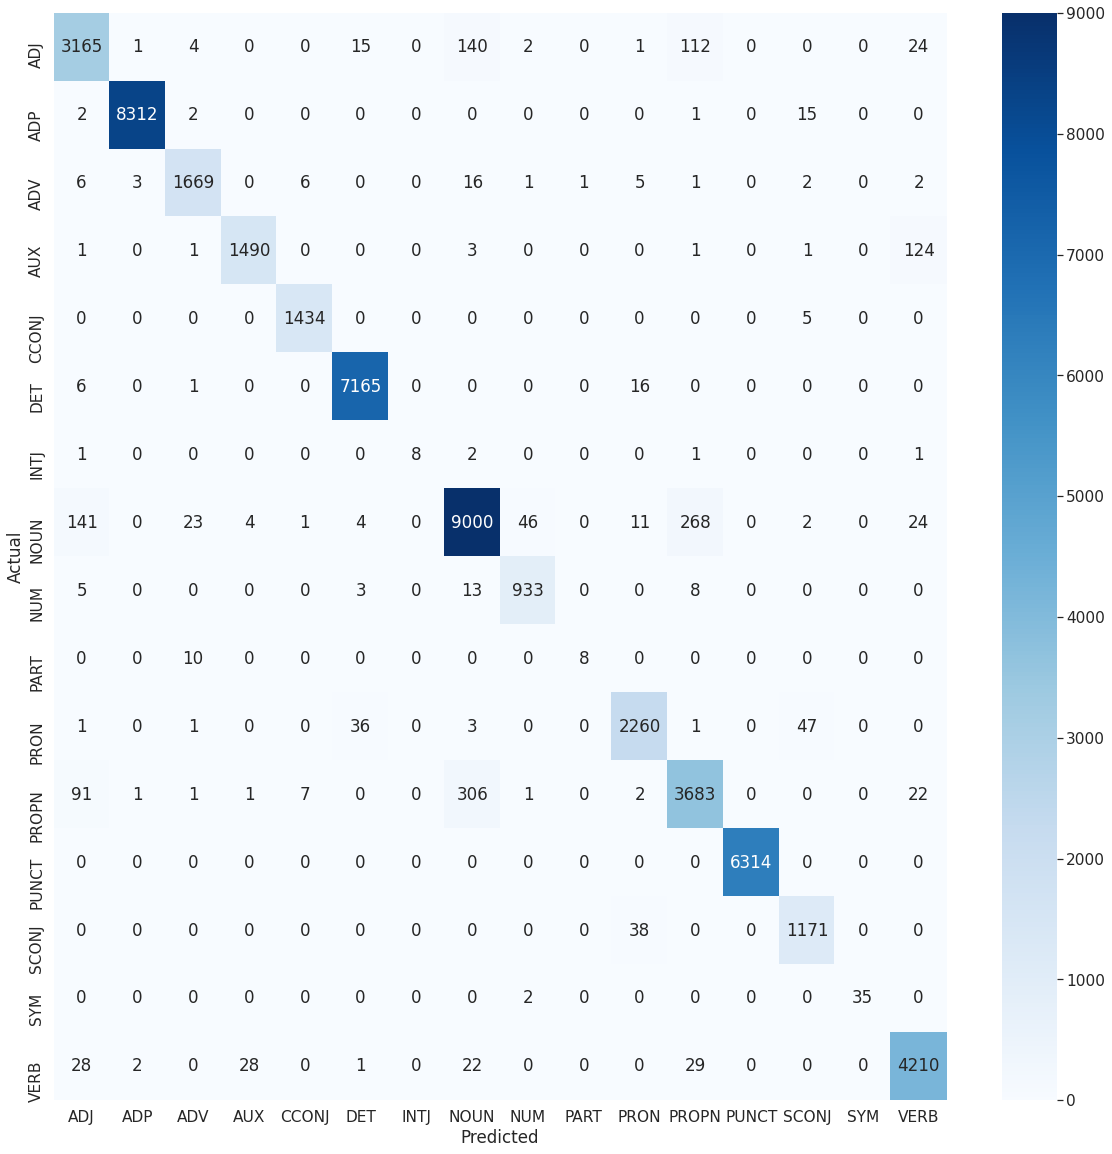

In [91]:
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)
sns.heatmap(cm.to_dataframe(), cmap="Blues", annot=True, fmt="d")

In [0]:
y_pred,y_true, words = get_pr(model, test_iterator, is_char=True, text=True)


In [0]:
def find_errors(pred, true, words):
    error_counter = Counter()
    support = 0
    for w, true, pred in zip(words, true, pred):
                if true != pred:
                    word = inxtoword[w]
                    error_counter[word] += 1
                support += 1
    return error_counter, support

errors, support = find_errors(y_pred, y_true, words)


In [100]:
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:')
for i in errors.most_common(20):
  print(i)


Total errors/Total words: 1760/52617 | Accuracy: 0.9666

Most common errors:
('barinas', 298)
('que', 75)
('como', 16)
('cuando', 13)
('no', 11)
('está', 10)
('estadounidense', 10)
('estado', 9)
('la', 9)
('rey', 8)
('pacto', 7)
('u', 7)
('mismo', 7)
('fuera', 6)
('poco', 6)
('están', 6)
('grandes', 6)
('rover', 6)
('mundiales', 6)
('división', 6)


## BERT

![alt text](https://project-seo.net/wp-content/uploads/2019/11/google-bert-algorithm.jpg)

This is one of the cutting-edge models in nlp that is so heavy that it usually can be trained only with batch size 32... We should try it as well.

“BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.”

![alt text](https://gluon-nlp.mxnet.io/_images/bert-sentence-pair.png)

In [78]:
! pip install transformers

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets

from transformers import BertTokenizer, BertModel

import numpy as np

import time
import random
import functools
import transformers

## Models to try:

We will used uncased models and try two variants: multilingual Bert and Bert embeddings trained specially for Spanish (This vriant is called Beto)

In [0]:
#'dccuchile/bert-base-spanish-wwm-uncased' 'dccuchile/bert-base-spanish-wwm-cased'

In [80]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
tokenizer.tokenize('Este hombre es muy guapo')

['Este', 'hombre', 'es', 'muy', 'guapo']

In [81]:
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, pad_token, unk_token)

[CLS] [PAD] [UNK]


In [82]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

4 1 3


In [83]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-cased']

print(max_input_length)

512


We have to define our fields one more time as Bert needs a special preprocessing: we cut our our sequence if needed and convert words to special BERT indices 

In [0]:
def cut_and_convert_to_id(tokens, tokenizer, max_input_length):
    tokens = tokens[:max_input_length-1]
    tokens = tokenizer.convert_tokens_to_ids(tokens)
    return tokens

def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

text_preprocessor = functools.partial(cut_and_convert_to_id,
                                      tokenizer = tokenizer,
                                      max_input_length = max_input_length)

tag_preprocessor = functools.partial(cut_to_max_length,
                                     max_input_length = max_input_length)

One important note is that Bert tokenizes words in a special way: so, one word may be divided into 2 parts. Since in our task there is strictly one tag assigned to one word, we cannot have sets of sentences and tags of different lengths. There are different ways how to handle this: I decided to try saving only the last part of each word and doubling the tags of the words that have been divided into 2 parts. That's why we need the following function

In [0]:
def tokenize_and_preserve_labels(sentence, text_labels, method='doubling'):
    tokenized_sentence = []
    labels = []

# case with doubling
    if method=='doubling':
      for word, label in zip(sentence, text_labels):
        
          tokenized_word = tokenizer.tokenize(word)
          n_subwords = len(tokenized_word)

          tokenized_sentence.extend(tokenized_word)

          labels.extend([label] * n_subwords)

# case with shortening
    if method == 'shortening':
        for word, label in zip(sentence, text_labels):
        
          tokenized_word = tokenizer.tokenize(word)[-1]

          tokenized_sentence.append(tokenized_word)

          labels.append(label)


    return tokenized_sentence, labels

In [86]:
#shortening
data_train = [list(zip(*sent)) for sent in tagged_sent_train]
print(data_train[0])
data_val = [list(zip(*sent)) for sent in tagged_sent_val]
print(data_val[0])
data_test = [list(zip(*sent)) for sent in tagged_sent_test]
print(data_test[0])

for i in data_train:
  
  i[0], i[1] = tokenize_and_preserve_labels(i[0], i[1])
  
for i in data_val:
  
  i[0], i[1] = tokenize_and_preserve_labels(i[0], i[1])

for i in data_test:
  
  i[0], i[1] = tokenize_and_preserve_labels(i[0], i[1])

[('El', 'presidente', 'del', 'órgano', 'regulador', 'de', 'las', 'Telecomunicaciones', 'se', 'mostró', 'partidario', 'de', 'completar', 'esta', 'liberalización', 'de', 'las', 'telecomunicaciones', 'con', 'otras', 'medidas', 'que', 'incentiven', 'la', 'competencia', 'como', 'puede', 'ser', 'abrir', 'el', 'acceso', 'a', 'la', 'información', 'de', 'los', 'clientes', 'de', 'Telefónica', 'a', 'otros', 'operadores', '.'), ('DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PRON', 'VERB', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'DET', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'PUNCT')]
[('El', 'gobernante', ',', 'con', 'ganada', 'fama', 'desde', 'que', 'llegó', 'hace', '16', 'meses', 'al', 'poder', 'de', 'explotar', 'al', 'máximo', 'su', 'oratoria', 'y', 'acusado', 'por', 'sus', 'detractores', 'de', 'incontinencia', 'verbal', ',', '

In [87]:
#doubling
data_train = [list(zip(*sent)) for sent in tagged_sent_train]
print(data_train[0])
data_val = [list(zip(*sent)) for sent in tagged_sent_val]
print(data_val[0])
data_test = [list(zip(*sent)) for sent in tagged_sent_test]
print(data_test[0])

for i in data_train:
  
  i[0], i[1] = tokenize_and_preserve_labels(i[0], i[1])
  
for i in data_val:
  
  i[0], i[1] = tokenize_and_preserve_labels(i[0], i[1])

for i in data_test:
  
  i[0], i[1] = tokenize_and_preserve_labels(i[0], i[1])

[('El', 'presidente', 'del', 'órgano', 'regulador', 'de', 'las', 'Telecomunicaciones', 'se', 'mostró', 'partidario', 'de', 'completar', 'esta', 'liberalización', 'de', 'las', 'telecomunicaciones', 'con', 'otras', 'medidas', 'que', 'incentiven', 'la', 'competencia', 'como', 'puede', 'ser', 'abrir', 'el', 'acceso', 'a', 'la', 'información', 'de', 'los', 'clientes', 'de', 'Telefónica', 'a', 'otros', 'operadores', '.'), ('DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PRON', 'VERB', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'DET', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'PUNCT')]
[('El', 'gobernante', ',', 'con', 'ganada', 'fama', 'desde', 'que', 'llegó', 'hace', '16', 'meses', 'al', 'poder', 'de', 'explotar', 'al', 'máximo', 'su', 'oratoria', 'y', 'acusado', 'por', 'sus', 'detractores', 'de', 'incontinencia', 'verbal', ',', '

In [24]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORDS = data.Field(use_vocab = False,
                  lower = True,
                  preprocessing = text_preprocessor,
                  init_token = init_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

TAGS = data.Field(unk_token = None,
                     init_token = '<pad>',
                     preprocessing = tag_preprocessor) # все токены нам извсетны

# создаем примеры
examples_train = []
for words, tags in data_train:
    examples_train.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORDS), ('tags', TAGS)]))

examples_val = []
for words, tags in data_val:
    examples_val.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORDS), ('tags', TAGS)]))

examples_test = []
for words, tags in data_test:
    examples_test.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORDS), ('tags', TAGS)]))

train_data =torchtext.data.Dataset(examples_train, fields=[('words', WORDS), ('tags', TAGS)])
valid_data = torchtext.data.Dataset(examples_val, fields=[('words', WORDS), ('tags', TAGS)])
test_data = torchtext.data.Dataset(examples_test, fields=[('words', WORDS), ('tags', TAGS)])
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 14305
Number of validation examples: 1654
Number of testing examples: 1721


In [25]:
print(vars(train_data.examples[0]))

{'words': [1040, 3599, 1072, 6322, 24552, 1008, 1089, 3245, 13317, 8732, 1062, 12048, 29533, 1008, 10563, 1359, 16014, 1008, 1089, 3245, 13317, 8732, 1051, 2074, 2160, 1038, 30394, 1375, 1030, 4220, 1184, 1499, 1200, 5867, 1040, 3209, 1013, 1030, 1924, 1008, 1065, 5615, 1008, 3245, 23015, 1013, 1759, 12072, 1009], 'tags': ['DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'PROPN', 'PROPN', 'PROPN', 'PRON', 'VERB', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', 'DET', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PROPN', 'ADP', 'DET', 'NOUN', 'PUNCT']}


In [88]:
#we don't build vocabulary of WORDS as it already contains integers

TAGS.build_vocab(train_data)

print(TAGS.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f87c65b8950>, {'<pad>': 0})


In [0]:
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key)

In [28]:
i = next(iter(train_iterator))
print(i.words.shape, i.tags.shape)

torch.Size([82, 32]) torch.Size([82, 32])


This is our model. Actually, it is quite simple, the main element here is the bert itself that returns itd hidden vector which is then feeded into a fc one to get a prediction.

In [0]:
class BERTPoSTagger(nn.Module):
    def __init__(self,
                 bert,
                 output_dim, 
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
    
        text = text.permute(1, 0)
        
        embedded = self.dropout(self.bert(text)[0])
                
        embedded = embedded.permute(1, 0, 2)
                    
        predictions = self.fc(self.dropout(embedded))
        
        
        return predictions

In [0]:
bert = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

In [0]:
OUTPUT_DIM = len(TAGS.vocab)
DROPOUT = 0.25

model = BERTPoSTagger(bert,
                      OUTPUT_DIM, 
                      DROPOUT)

We use one of the recommended for transformers lr and also. a schedular to make our our function converge more smoothly


In [0]:
epochs = 5
lr = 5e-5 #1e-5 5e-5
warmup_steps = len(train_iterator) // 2
t_total = len(train_iterator) * epochs
TAG_PAD_IDX = TAGS.vocab.stoi[TAGS.pad_token]

optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters()], "weight_decay": 0.0},
]

criterion = torch.nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
)
model.to(device)
criterion = criterion.to(device)


In [0]:
LEARNING_RATE = 5e-5 #5e-5   5e-4  5e-8  1e-4 и dropout 4??? попробовать

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
TAG_PAD_IDX = TAGS.vocab.stoi[TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model = model.to(device)
criterion = criterion.to(device)

P.S. Before training we have to redefine the helper functions that we have defined in the beggining as for BERT we use them and not those for models with CRF

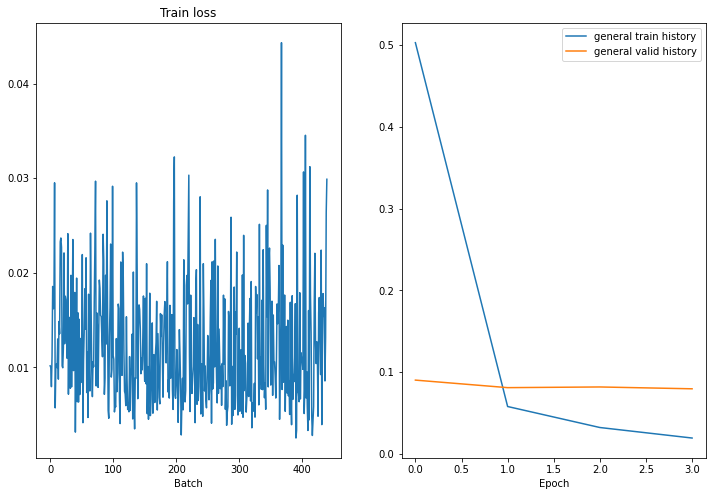

Epoch: 05 | Time: 2m 16s
	Train Loss: 0.012 | Train PPL:   1.012
	 Val. Loss: 0.086 |  Val. PPL:   1.089


In [33]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, scheduler=scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bert_beto.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [34]:
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_beto.pt')

Accuracy train: 99.763 %
Accuracy valid: 98.173 %
Accuracy test: 98.096 %
F1 score macro train: 93.63838129998005 %
F1 score macro valid: 93.1873497508665 %
F1 score macro test: 96.28393329568885 %
F1 score micro train: 99.76244107425084 %
F1 score micro valid: 98.17251702470638 %
F1 score micro test: 98.09573925770009 %


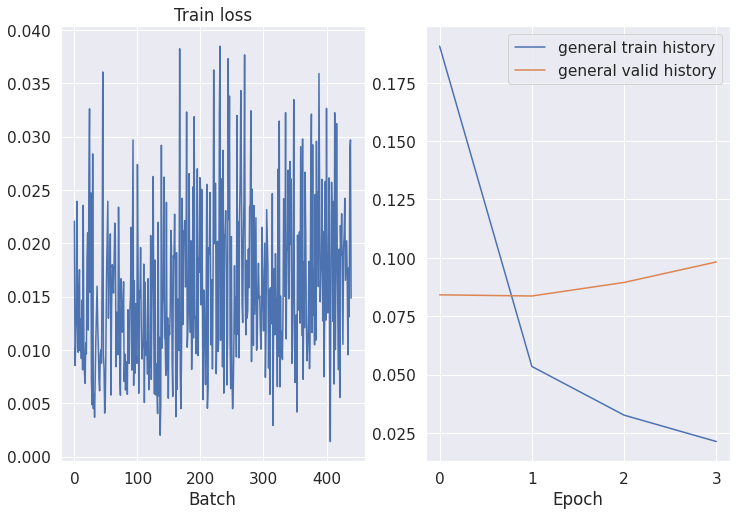

Epoch: 05 | Time: 3m 25s
	Train Loss: 0.016 | Train PPL:   1.016
	 Val. Loss: 0.101 |  Val. PPL:   1.106


In [172]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, scheduler=scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bert_beto.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [173]:
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_beto.pt')

Accuracy train: 99.166 %
Accuracy valid: 98.015 %
Accuracy test: 97.841 %
F1 score macro train: 91.68761959485253 %
F1 score macro valid: 92.44537590983643 %
F1 score macro test: 94.9054632548608 %
F1 score micro train: 99.1637727837055 %
F1 score micro valid: 98.01475084072149 %
F1 score micro test: 97.84100195754223 %


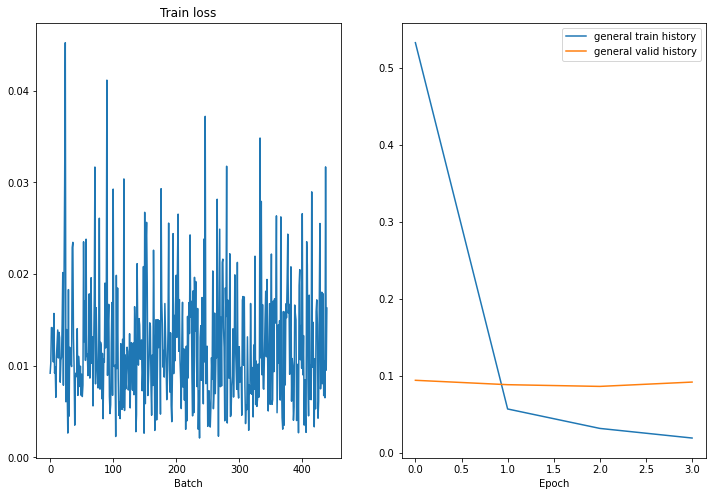

Epoch: 05 | Time: 6m 36s
	Train Loss: 0.012 | Train PPL:   1.012
	 Val. Loss: 0.095 |  Val. PPL:   1.100


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, scheduler=scheduler)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bert_beto.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_beto.pt')

Accuracy train: 99.585 %
Accuracy valid: 98.173 %
Accuracy test: 98.028 %
F1 score macro train: 92.97397530775831 %
F1 score macro valid: 93.63169417846166 %
F1 score macro test: 95.62792268207345 %
F1 score micro train: 99.58739765527778 %
F1 score micro valid: 98.17251702470638 %
F1 score micro test: 98.02831724523524 %


Then, we also try multibert with the same parameters but results are not that good

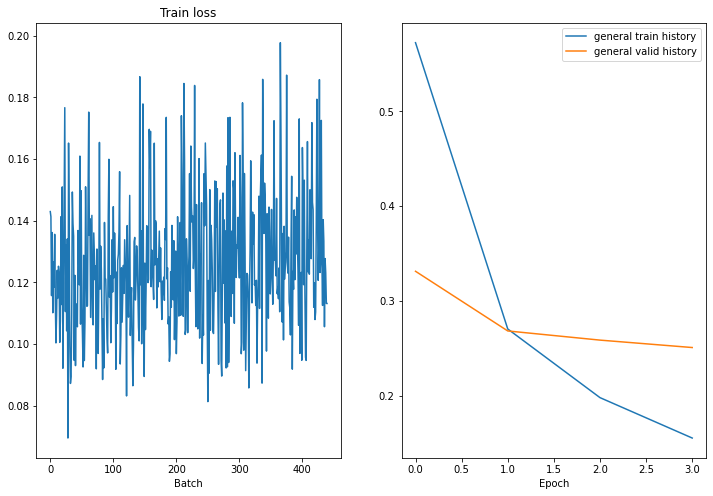

Epoch: 05 | Time: 7m 39s
	Train Loss: 0.126 | Train PPL:   1.134
	 Val. Loss: 0.257 |  Val. PPL:   1.293


In [0]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5 #5 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model-bert_mult.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [0]:
#5e-5 dropout 0.25
print_quality(model, train_iterator, valid_iterator, test_iterator, name='best-val-model-bert_mult.pt') #'best-val-model-bert_mull.pt'

Accuracy train: 98.053 %
Accuracy valid: 96.173 %
Accuracy test: 96.174 %
F1 score macro train: 89.05568052354178 %
F1 score macro valid: 92.24466391677592 %
F1 score macro test: 92.78499356699523 %
F1 score micro train: 98.042293188219 %
F1 score micro valid: 96.17254243310023 %
F1 score micro test: 96.17381798305547 %


So, it is the best BERT model and the best model that we have managed to build:

* Accuracy train: 99.59 %
* Accuracy valid: 98.161 %
* Accuracy test: 98.102 %
* F1 score macro train: 93.02532217302415 %
* F1 score macro valid: 93.62235883438579 %
* F1 score macro test: 96.09499765351097 %
* F1 score micro train: 99.5864208504844 %
* F1 score micro valid: 98.16100273053262 %
* F1 score micro test: 98.10231701501372 %

In [0]:
report, cm = statistics(model, test_iterator, TAGS, pred_func=get_preds, name='best-val-model-bert_beto.pt')
print(report)

              precision    recall  f1-score   support

        NOUN       0.97      0.97      0.97     11309
         ADP       1.00      1.00      1.00      8333
         DET       0.99      1.00      1.00      7191
       PROPN       0.96      0.95      0.96      7260
       PUNCT       1.00      1.00      1.00      6344
        VERB       0.98      0.99      0.99      5678
         ADJ       0.96      0.96      0.96      4636
        PRON       0.98      0.98      0.98      2356
         ADV       0.98      0.99      0.98      1807
         AUX       0.98      0.98      0.98      1636
       CCONJ       1.00      1.00      1.00      1439
         NUM       0.97      0.95      0.96      1507
       SCONJ       0.97      0.99      0.98      1209
         SYM       0.70      0.91      0.80        70
        INTJ       1.00      0.83      0.91        18
        PART       0.93      0.78      0.85        18

    accuracy                           0.98     60811
   macro avg       0.96   

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


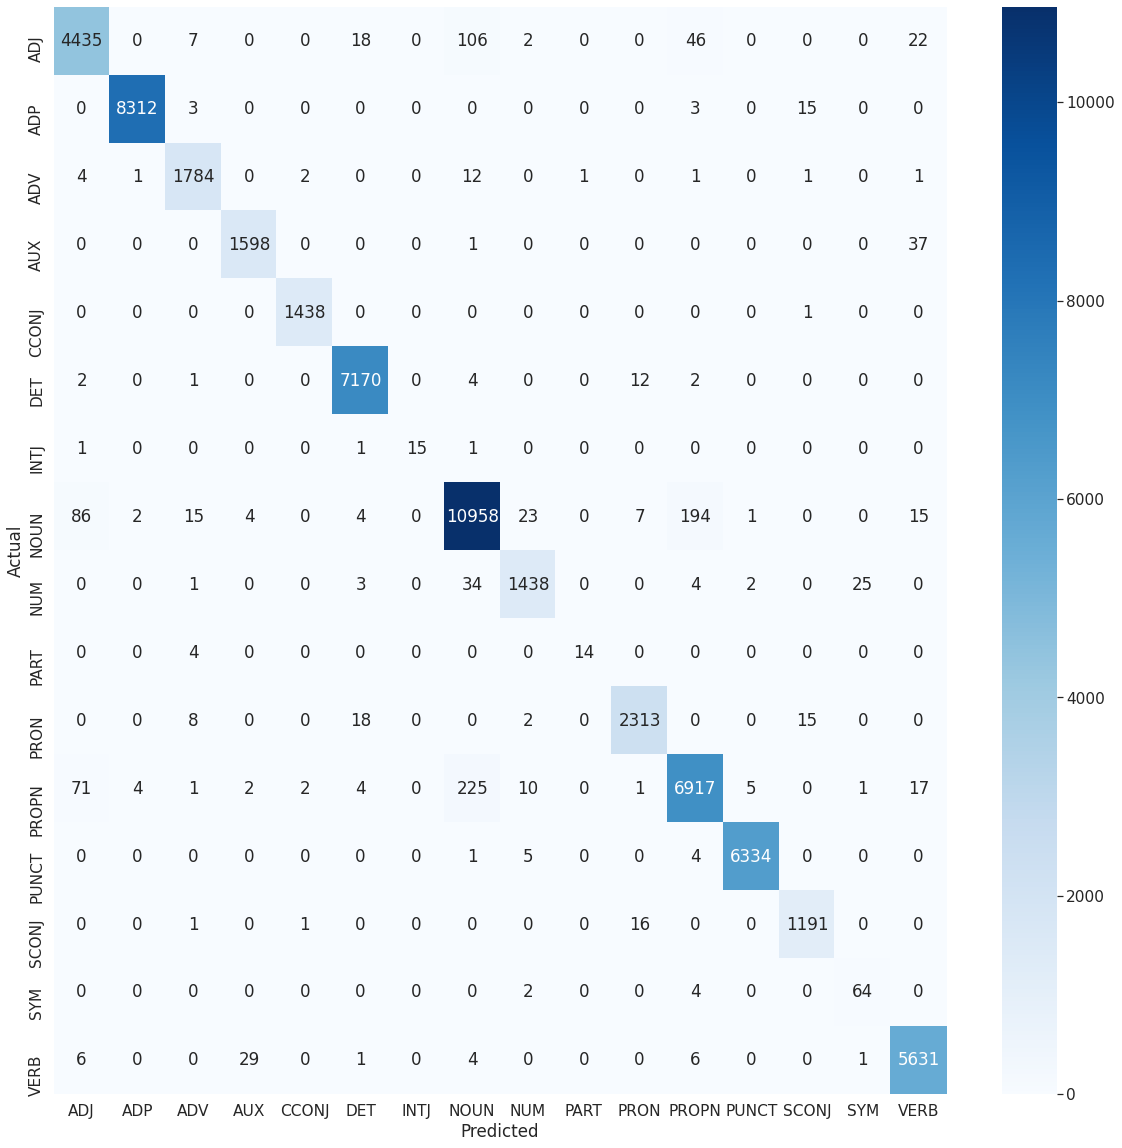

In [0]:
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm.to_dataframe(), cmap="Blues", annot=True, fmt="d")


In [0]:
from collections import Counter

In [0]:
y_pred,y_true, words = get_preds(model, test_iterator, is_char=False, text=True)

In [0]:
def find_errors(pred, true, words):
    error_counter = Counter()
    support = 0
    for w, true, pred in zip(words, true, pred):
                if true != pred:
                    word = tokenizer.convert_ids_to_tokens([w])[0]
                    error_counter[word] += 1
                support += 1
    return error_counter, support

In [0]:
errors, support = find_errors(y_pred, y_true, words)

In [0]:
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:')
for i in errors.most_common(20):
  print(i)

Total errors/Total words: 1199/60811 | Accuracy: 0.9803

Most common errors:
('[UNK]', 32)
('que', 22)
('##s', 19)
('.', 19)
('como', 19)
('gobierno', 9)
('1', 8)
('una', 7)
('j', 7)
('m', 7)
('un', 7)
('no', 7)
('cuando', 7)
(',', 7)
('ayuntamiento', 6)
('##a', 6)
('##o', 6)
('##r', 6)
('00', 6)
('-', 6)


In [177]:
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:')
for i in errors.most_common(20):
  print(i)

Total errors/Total words: 1136/52617 | Accuracy: 0.9784

Most common errors:
('##s', 36)
('que', 30)
('[UNK]', 29)
('##a', 18)
('como', 17)
('##o', 14)
('cuando', 13)
('.', 12)
('##es', 11)
('algo', 10)
('##7', 8)
('todo', 8)
('##t', 8)
('una', 7)
('##da', 7)
('##ro', 7)
('la', 7)
('##do', 6)
('gobierno', 6)
('pacto', 6)


In [0]:
def tag_sentence(model, device, sentence, tokenizer, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        tokens = tokenizer.tokenize(sentence)
    else:
        tokens = sentence
    
    numericalized_tokens = tokenizer.convert_tokens_to_ids(tokens)
    numericalized_tokens = [text_field.init_token] + numericalized_tokens
        
    unk_idx = text_field.unk_token
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    predicted_tags = predicted_tags[1:]
        
    assert len(tokens) == len(predicted_tags)
    
    return tokens, predicted_tags, unks

In [0]:
sentence = 'Mis amigos quieran tener mucho dinero.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence,
                                  tokenizer,
                                  WORDS, 
                                  TAGS)


In [0]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

DET		Mis
NOUN		amigos
VERB		quieran
VERB		tener
DET		mucho
NOUN		dinero
PUNCT		.


In [0]:
sentence = 'El medio ambiente se encuentra en peligro por diversas amenazas que ponen en peligro no solo a los ecosistemas, sino a todos los seres humanos.'
tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence,
                                  tokenizer,
                                  WORDS, 
                                  TAGS)


In [0]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

DET		El
NOUN		medio
NOUN		ambiente
PRON		se
AUX		encuentra
ADP		en
NOUN		peligro
ADP		por
DET		diversas
NOUN		amenazas
PRON		que
VERB		ponen
ADP		en
NOUN		peligro
PART		no
NOUN		solo
ADP		a
DET		los
NOUN		ecosistemas
PUNCT		,
CCONJ		sino
ADP		a
DET		todos
DET		los
NOUN		seres
ADJ		humanos
PUNCT		.


In [179]:
tokenizer.tokenize('Habitualmente, la gente prefiere relajarse durante las vacaciones')

['Hab',
 '##it',
 '##ualmente',
 ',',
 'la',
 'gente',
 'prefiere',
 'relajarse',
 'durante',
 'las',
 'vacaciones']